# GluonTS - Transfer Learning Approach

- Two datasets: A and B
- Dataset A: Dataset subsetted by frequency, i.e. `m4_monthly`
- Dataset B: Dataset subsetted by frequency and by domain, i.e. `m4_monthly_industry`
- Network A: Trained on dataset A
- Network B: Trained on dataset B
- Both networks are evaluated on dataset B. 

- Adjust epochs to account for different size of the datasets

Goal: Check TZ1: "Does the network learn from time series of the same domain or is it helpful to use time series from other domains?"

- Both networks are trained for ten trials (deepar) or three trials (deepstate)

Note that there are already results where a network is trained on `m4_frequency_domain` and evaluated on the same network.

In [22]:
!pip install mxnet=="1.4.1"

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [23]:
!pip install gluonts

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Imports



In [24]:
import gluonts
import mxnet

print(gluonts.__version__)
print(mxnet.__version__)

0.4.2
1.4.1


In [25]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar


In [26]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_end032014', 'm4_monthly_end052015', 'm4_monthly_end092007', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_finance', 'm4_quarterly_id', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_qu

In [27]:
dataset = get_dataset("m4_weekly", regenerate=False)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly.


### mv the data

Before moving on: Move the respective data according the required folder structure. In AWS:

- `mv [dataname] ../../.mxnet/gluon-ts/datasets/`

In [28]:
dataname_a = "m4_monthly_atm"
dataset_a = get_dataset(dataname_a, regenerate=False)
len(dataset_a.train)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_atm.


48000

In [29]:
dataname_b = "m4_monthly_industry"
dataset_b = get_dataset(dataname_b, regenerate=False)
len(dataset_b.train)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_industry.


10017

## Check the datasets 

### Dataset A


dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])
length train: 48000
length test: 48000

start:
 1750-01-31 00:00:00
target:
 [8000. 8350. 8570. 7700. 7080. 6520. 6070. 6650. 6830. 5710.]
feat_static_cat:
 [1]


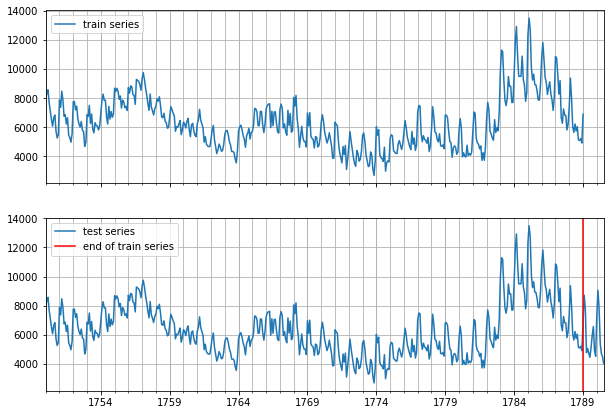

In [30]:
train_entry_a = next(iter(dataset_a.train))
test_entry_a = next(iter(dataset_a.test))

print(train_entry_a.keys())
print(test_entry_a.keys())
print("length train:", len(dataset_a.train))
print("length test:", len(dataset_a.test))


print("\nstart:\n",train_entry_a["start"])
print("target:\n", train_entry_a["target"][:10])
print("feat_static_cat:\n", train_entry_a["feat_static_cat"])

train_series_a = to_pandas(train_entry_a)
test_series_a = to_pandas(test_entry_a)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series_a.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series_a.plot(ax=ax[1])
ax[1].axvline(train_series_a.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

## Dataset B

dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])
length train: 10017
length test: 10017

start:
 1750-01-31 00:00:00
target:
 [8370. 8430. 7880. 8160. 8290. 8000. 8240. 7840. 8040. 7930.]
feat_static_cat:
 [1]


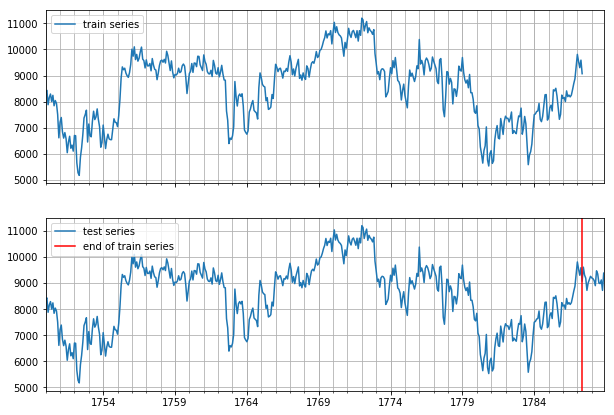

In [31]:
train_entry_b = next(iter(dataset_b.train))
test_entry_b = next(iter(dataset_b.test))

print(train_entry_b.keys())
print(test_entry_b.keys())
print("length train:", len(dataset_b.train))
print("length test:", len(dataset_b.test))

print("\nstart:\n",train_entry_b["start"])
print("target:\n", train_entry_b["target"][:10])
print("feat_static_cat:\n", train_entry_b["feat_static_cat"])

train_series_b = to_pandas(train_entry_b)
test_series_b = to_pandas(test_entry_b)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series_b.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series_b.plot(ax=ax[1])
ax[1].axvline(train_series_b.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

## Comparison of both datasets

- Compare whether both datasets have the same length


In [32]:
# Check length
print("Length test train:", len(dataset_a.train) == len(dataset_b.train))
print("Length test test:", len(dataset_a.test) == len(dataset_b.test))

# Check frequency
print("Frequency test:",(dataset_a.metadata.freq == dataset_b.metadata.freq))


Length test train: False
Length test test: False
Frequency test: True


## Modeling: DeepAR

In [33]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator

In [14]:
# A: dataset_a
# B: dataset_b
print(dataset_a)
print("\n", dataset_b)

TrainDatasets(metadata=MetaData(freq='M', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat', cardinality='48000')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=18), train=<gluonts.dataset.common.FileDataset object at 0x7f4ee0627ef0>, test=<gluonts.dataset.common.FileDataset object at 0x7f4edfd56be0>)

 TrainDatasets(metadata=MetaData(freq='M', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat', cardinality='10017')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=18), train=<gluonts.dataset.common.FileDataset object at 0x7f4edfd56400>, test=<gluonts.dataset.common.FileDataset object at 0x7f4edfd564a8>)


In [53]:
print(dataname_a)
print(dataname_b)

m4_monthly_atm
m4_monthly_industry


In [54]:
def deepar_train_eval(dataname_a, dataname_b, seed=42, epochs=100, num_batches=100):
    """
    Function that trains a network using data from dataset B and evaluates the trained network on dataset A.
    Dataset A is the dataset of interest for our analysis. 
    """    
    
    dataset_a = get_dataset(dataname_a, regenerate=False)
    dataset_b = get_dataset(dataname_b, regenerate=False)
    
    # Assert checks
    assert (dataset_a.metadata.freq == dataset_b.metadata.freq)
#     assert ( len(dataset_a.train)==len(dataset_b.train) )
#     assert ( len(dataset_a.test)==len(dataset_b.test))
    
    mx.random.seed(seed)
    np.random.seed(seed)

    # define trainer
    trainer=Trainer(
        ctx=mx.cpu(),
        epochs=epochs,
        num_batches_per_epoch=num_batches,
        learning_rate=1e-3,
    )

    estimator=DeepAREstimator(
        trainer=trainer,
        context_length=dataset_a.metadata.prediction_length,
        prediction_length=dataset_a.metadata.prediction_length,
        freq=dataset_a.metadata.freq,
        use_feat_static_cat=False,
    )
    
#     estimator = DeepAREstimator(
#         trainer=trainer,
#         cardinality= [
#             feat_static_cat.cardinality 
#             for feat_static_cat in dataset_a.metadata.feat_static_cat
#         ],
#         context_length=dataset_a.metadata.prediction_length,
#         prediction_length=dataset_a.metadata.prediction_length,
#         freq=dataset_a.metadata.freq,
#         use_feat_static_cat=True
#     )
    
    # predictor trained on dataset_a, evaluated on dataset_b
    predictor_a=estimator.train(training_data=dataset_a.train)
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset_b.test, predictor=predictor_a, num_samples=100
    )
    
    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series = len(dataset_b.test))
    
    metrics=["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}
    
    output["seed"]=seed
    output["epochs"]=epochs
    output["num_batches"]=num_batches
    output["train data"]=dataname_a
    output["eval data"]=dataname_b
    
    df=pd.DataFrame([output])

    return df

    

## Subsets

In [55]:
print(dataname_a)
print(dataname_b)

m4_monthly_atm
m4_monthly_industry


## Study 1: `m4_monthly` vs. `m4_monthly_industry` trained network

### Run I.: Training: A, Eval: B

- 10 trials training a network on dataset a and evaluating network on data a

In [56]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a=dataname_a, dataname_b=dataname_b, seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_atm.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_industry.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]

Next seed: 42


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 50/50 [00:01<00:00, 27.82it/s, avg_epoch_loss=7.57]
INFO:root:Epoch[0] Elapsed time 1.799 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.565155
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 32.58it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[1] Elapsed time 1.536 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.121286
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 33.22it/s, avg_epoch_loss=7.67]
INFO:root:Epoch[2] Elapsed time 1.507 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.671857
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 31.42it/s, avg_epoch_loss=7.58]
INFO:root:Epoch[3] Elapsed time 1.594 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.575479
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 28.01it/s, avg_epoch_loss=7.51]
INFO

100%|██████████| 50/50 [00:01<00:00, 32.56it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[37] Elapsed time 1.538 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.036436
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 27.67it/s, avg_epoch_loss=7.3]
INFO:root:Epoch[38] Elapsed time 1.809 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.304229
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 35.03it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[39] Elapsed time 1.429 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.304364
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 34.78it/s, avg_epoch_loss=5.61]
INFO:root:Epoch[40] Elapsed time 1.440 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.614590
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 32.22it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[41] Elapsed time 1.554 seconds
INFO:r

100%|██████████| 50/50 [00:01<00:00, 34.10it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[74] Elapsed time 1.468 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.153359
INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 32.26it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[75] Elapsed time 1.552 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.880396
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 33.28it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[76] Elapsed time 1.506 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.962043
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 33.13it/s, avg_epoch_loss=7.94]
INFO:root:Epoch[77] Elapsed time 1.512 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.938919
INFO:root:Epoch[78] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 30.47it/s, avg_epoch_loss

      MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.31119  0.148395  27.29755            0.126111            0.109562    42   

   epochs  num_batches      train data            eval data  
0     100           50  m4_monthly_atm  m4_monthly_industry  
Next seed: 43


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 50/50 [00:01<00:00, 30.03it/s, avg_epoch_loss=7.3]
INFO:root:Epoch[0] Elapsed time 1.667 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.304947
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 33.02it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[1] Elapsed time 1.516 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.151964
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 33.99it/s, avg_epoch_loss=7.71]
INFO:root:Epoch[2] Elapsed time 1.473 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.712131
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 33.91it/s, avg_epoch_loss=7.54]
INFO:root:Epoch[3] Elapsed time 1.476 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.544787
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.06it/s, avg_epoch_loss=7.46]
INFO:

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 35.62it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[37] Elapsed time 1.407 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.215148
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 29.14it/s, avg_epoch_loss=7.56]
INFO:root:Epoch[38] Elapsed time 1.717 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.562609
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 30.79it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[39] Elapsed time 1.626 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.717391
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 35.97it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[40] Elapsed time 1.392 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.948212
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 32.11it/s, avg_epoch_loss=6.76]
IN

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.436230
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:01<00:00, 34.04it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[74] Elapsed time 1.471 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.418795
INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 35.59it/s, avg_epoch_loss=5.92]
INFO:root:Epoch[75] Elapsed time 1.406 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.919770
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 35.35it/s, avg_epoch_loss=7.54]
INFO:root:Epoch[76] Elapsed time 1.417 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.542834
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 32.75it/s, avg_epoch_loss=8.17]
INFO:root:Epoch[77] Elapsed time 1.529 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=8.170853
INFO:root:E

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.209828  0.145595  23.79778            0.123073            0.090085    43   

   epochs  num_batches      train data            eval data  
0     100           50  m4_monthly_atm  m4_monthly_industry  
Next seed: 44


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 50/50 [00:01<00:00, 29.50it/s, avg_epoch_loss=7.7]
INFO:root:Epoch[0] Elapsed time 1.697 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.703597
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 31.42it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[1] Elapsed time 1.593 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.093152
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 32.45it/s, avg_epoch_loss=7.68]
INFO:root:Epoch[2] Elapsed time 1.543 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.682068
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 30.99it/s, avg_epoch_loss=7.51]
INFO:root:Epoch[3] Elapsed time 1.615 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.507164
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 25.02it/s, avg_epoch_loss=7.43]
INFO:

100%|██████████| 50/50 [00:01<00:00, 32.11it/s, avg_epoch_loss=7.01]
INFO:root:Epoch[37] Elapsed time 1.559 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.007345
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 28.66it/s, avg_epoch_loss=7.46]
INFO:root:Epoch[38] Elapsed time 1.748 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.460616
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 33.15it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[39] Elapsed time 1.510 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.040884
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 36.38it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[40] Elapsed time 1.376 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.760281
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 35.96it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[41] Elapsed time 1.392 seconds
INFO:

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.457974
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:01<00:00, 35.64it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[74] Elapsed time 1.407 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.222672
INFO:root:Loading parameters from best epoch (34)
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 35.05it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[75] Elapsed time 1.429 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.030058
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 31.65it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[76] Elapsed time 1.582 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.741092
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 35.50it/s, avg_epoch_loss=8.26]
INFO:root:Epoch[77] Elapsed time 1.412 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=8.255534
INFO:root:E

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.154088  0.179612  57.698145            0.157825            0.175497   

   seed  epochs  num_batches      train data            eval data  
0    44     100           50  m4_monthly_atm  m4_monthly_industry  
Next seed: 45


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 50/50 [00:01<00:00, 28.58it/s, avg_epoch_loss=7.5]
INFO:root:Epoch[0] Elapsed time 1.751 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.495279
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 31.77it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[1] Elapsed time 1.576 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.201194
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 33.60it/s, avg_epoch_loss=7.74]
INFO:root:Epoch[2] Elapsed time 1.490 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.737118
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 34.56it/s, avg_epoch_loss=7.49]
INFO:root:Epoch[3] Elapsed time 1.448 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.488618
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 28.06it/s, avg_epoch_loss=7.55]
INFO:r

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 35.39it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[37] Elapsed time 1.415 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.243707
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 29.80it/s, avg_epoch_loss=7.54]
INFO:root:Epoch[38] Elapsed time 1.681 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.541411
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 34.45it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[39] Elapsed time 1.453 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.747436
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 35.55it/s, avg_epoch_loss=5.98]
INFO:root:Epoch[40] Elapsed time 1.408 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.981058
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 36.07it/s, avg_epoch_loss=6.75]
IN

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.215814  0.146943  30.159385            0.126268            0.098714   

   seed  epochs  num_batches      train data            eval data  
0    45     100           50  m4_monthly_atm  m4_monthly_industry  
Next seed: 46


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 50/50 [00:01<00:00, 29.89it/s, avg_epoch_loss=7.54]
INFO:root:Epoch[0] Elapsed time 1.674 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.540785
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 30.63it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[1] Elapsed time 1.635 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.168285
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 31.72it/s, avg_epoch_loss=7.63]
INFO:root:Epoch[2] Elapsed time 1.578 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.625948
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 32.93it/s, avg_epoch_loss=7.47]
INFO:root:Epoch[3] Elapsed time 1.520 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.467640
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 28.12it/s, avg_epoch_loss=7.42]
INFO

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 26.04it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[37] Elapsed time 1.924 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.128958
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:02<00:00, 24.34it/s, avg_epoch_loss=7.42]
INFO:root:Epoch[38] Elapsed time 2.056 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.419349
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 30.39it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[39] Elapsed time 1.647 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.532232
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 30.78it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[40] Elapsed time 1.626 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.872507
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 32.04it/s, avg_epoch_loss=6.64]
IN

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.533709
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:01<00:00, 33.92it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[74] Elapsed time 1.476 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.249367
INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 34.76it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[75] Elapsed time 1.440 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.972177
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 32.26it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[76] Elapsed time 1.552 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.718172
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 32.53it/s, avg_epoch_loss=8.14]
INFO:root:Epoch[77] Elapsed time 1.538 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=8.142453
INFO:root:E

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.123038  0.142696  21.785767            0.120227            0.089309   

   seed  epochs  num_batches      train data            eval data  
0    46     100           50  m4_monthly_atm  m4_monthly_industry  
Next seed: 47


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 50/50 [00:01<00:00, 30.22it/s, avg_epoch_loss=7.88]
INFO:root:Epoch[0] Elapsed time 1.656 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.876481
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 32.87it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[1] Elapsed time 1.523 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.172874
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 33.88it/s, avg_epoch_loss=7.68]
INFO:root:Epoch[2] Elapsed time 1.478 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.676772
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 31.94it/s, avg_epoch_loss=7.51]
INFO:root:Epoch[3] Elapsed time 1.567 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.511193
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 29.83it/s, avg_epoch_loss=7.45]
INFO

INFO:root:Loading parameters from best epoch (6)
INFO:root:Epoch[37] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 33.52it/s, avg_epoch_loss=7.76]
INFO:root:Epoch[37] Elapsed time 1.493 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.763957
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 27.86it/s, avg_epoch_loss=7.85]
INFO:root:Epoch[38] Elapsed time 1.796 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.848124
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 34.34it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[39] Elapsed time 1.458 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.472788
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 34.26it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[40] Elapsed time 1.461 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.098476
INFO:root:Epoch[41] Learning rate is 0.000125
100%|██████████| 5

       MASE    sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.310256  0.15238  33.66883            0.131126            0.124073    47   

   epochs  num_batches      train data            eval data  
0     100           50  m4_monthly_atm  m4_monthly_industry  
Next seed: 48


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 50/50 [00:01<00:00, 30.20it/s, avg_epoch_loss=7.65]
INFO:root:Epoch[0] Elapsed time 1.657 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.649923
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 33.33it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[1] Elapsed time 1.502 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.258466
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 33.63it/s, avg_epoch_loss=7.72]
INFO:root:Epoch[2] Elapsed time 1.488 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.723490
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 33.27it/s, avg_epoch_loss=7.54]
INFO:root:Epoch[3] Elapsed time 1.505 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.535432
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 29.92it/s, avg_epoch_loss=7.68]
INFO

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 33.31it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[37] Elapsed time 1.504 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.253154
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 29.79it/s, avg_epoch_loss=7.61]
INFO:root:Epoch[38] Elapsed time 1.681 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.607333
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 29.65it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[39] Elapsed time 1.688 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.764556
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 33.98it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[40] Elapsed time 1.475 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.058153
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 32.83it/s, avg_epoch_loss=6.75]
IN

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.307142  0.150507  32.708626            0.129622            0.120089   

   seed  epochs  num_batches      train data            eval data  
0    48     100           50  m4_monthly_atm  m4_monthly_industry  
Next seed: 49


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 50/50 [00:01<00:00, 30.82it/s, avg_epoch_loss=7.77]
INFO:root:Epoch[0] Elapsed time 1.624 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.768627
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 32.67it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[1] Elapsed time 1.533 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.229126
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 34.39it/s, avg_epoch_loss=7.69]
INFO:root:Epoch[2] Elapsed time 1.456 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.688507
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 33.31it/s, avg_epoch_loss=7.57]
INFO:root:Epoch[3] Elapsed time 1.503 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.565566
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 30.17it/s, avg_epoch_loss=7.67]
INFO

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 34.31it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[37] Elapsed time 1.459 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.174100
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 28.53it/s, avg_epoch_loss=7.58]
INFO:root:Epoch[38] Elapsed time 1.754 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.576328
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 35.07it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[39] Elapsed time 1.428 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.780864
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 36.27it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[40] Elapsed time 1.380 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.018167
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 34.24it/s, avg_epoch_loss=6.76]
IN

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.697247
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:01<00:00, 34.46it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[74] Elapsed time 1.453 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.357467
INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 32.51it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[75] Elapsed time 1.540 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.204150
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 33.80it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[76] Elapsed time 1.481 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.639589
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 33.89it/s, avg_epoch_loss=8.02]
INFO:root:Epoch[77] Elapsed time 1.478 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=8.022610
INFO:root:Ep

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.193965  0.146588  23.665784            0.123977            0.098121   

   seed  epochs  num_batches      train data            eval data  
0    49     100           50  m4_monthly_atm  m4_monthly_industry  
Next seed: 50


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 50/50 [00:01<00:00, 28.70it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[0] Elapsed time 1.744 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.305495
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 29.81it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[1] Elapsed time 1.680 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.136765
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 32.18it/s, avg_epoch_loss=7.68]
INFO:root:Epoch[2] Elapsed time 1.556 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.676699
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 32.69it/s, avg_epoch_loss=7.51]
INFO:root:Epoch[3] Elapsed time 1.531 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.512092
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 28.65it/s, avg_epoch_loss=7.49]
INFO

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 33.18it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[37] Elapsed time 1.509 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.150585
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 27.29it/s, avg_epoch_loss=7.55]
INFO:root:Epoch[38] Elapsed time 1.834 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.546708
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 34.94it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[39] Elapsed time 1.433 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.697201
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 34.71it/s, avg_epoch_loss=5.98]
INFO:root:Epoch[40] Elapsed time 1.442 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.979078
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 31.82it/s, avg_epoch_loss=6.64]
INF

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.182857  0.146773  29.779384            0.124433            0.104182   

   seed  epochs  num_batches      train data            eval data  
0    50     100           50  m4_monthly_atm  m4_monthly_industry  
Next seed: 51


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 50/50 [00:01<00:00, 27.97it/s, avg_epoch_loss=7.43]
INFO:root:Epoch[0] Elapsed time 1.789 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.428331
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 30.89it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[1] Elapsed time 1.621 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.107785
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 32.34it/s, avg_epoch_loss=7.58]
INFO:root:Epoch[2] Elapsed time 1.548 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.576896
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 31.63it/s, avg_epoch_loss=7.46]
INFO:root:Epoch[3] Elapsed time 1.583 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.464261
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.09it/s, avg_epoch_loss=7.61]
INFO

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 32.68it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[37] Elapsed time 1.532 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.180391
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 29.72it/s, avg_epoch_loss=7.58]
INFO:root:Epoch[38] Elapsed time 1.684 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.576194
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 35.80it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[39] Elapsed time 1.398 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.638465
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 36.38it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[40] Elapsed time 1.376 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.970598
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 36.22it/s, avg_epoch_loss=6.68]
IN

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.161403  0.145217  27.285432            0.123051            0.099872   

   seed  epochs  num_batches      train data            eval data  
0    51     100           50  m4_monthly_atm  m4_monthly_industry  


MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.311190  0.148395  27.297550            0.126111            0.109562   
0  1.209828  0.145595  23.797780            0.123073            0.090085   
0  2.154088  0.179612  57.698145            0.157825            0.175497   
0  1.215814  0.146943  30.159385            0.126268            0.098714   
0  1.123038  0.142696  21.785767            0.120227            0.089309   
0  1.310256  0.152380  33.668830            0.131126            0.124073   
0  1.307142  0.150507  32.708626            0.129622            0.120089   
0  1.193965  0.146588  23.665784            0.123977            0.098121   
0  1.182857  0.146773  29.779384            0.124433            0.104182   
0  1.161403  0.145217  27.285432            0.123051            0.099872   

   seed  epochs  num_batches      train data            eval data  
0    42     100           50  m4_monthly_atm  m4_monthly_industry  
0    43     100           50  m4_monthly_atm  m4_monthly_industry  
0    44     100           50  m4_monthly_atm  m4_monthly_industry  
0    45     100           50  m4_monthly_atm  m4_monthly_industry  
0    46     100           50  m4_monthly_atm  m4_monthly_industry  
0    47     100           50  m4_monthly_atm  m4_monthly_industry  
0    48     100           50  m4_monthly_atm  m4_monthly_industry  
0    49     100           50  m4_monthly_atm  m4_monthly_industry  
0    50     100           50  m4_monthly_atm  m4_monthly_industry  
0    51     100           50  m4_monthly_atm  m4_monthly_industry

In [57]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a=dataname_a, dataname_b=dataname_b, seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_atm.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_industry.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]

Next seed: 42


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:03<00:00, 31.69it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[0] Elapsed time 3.157 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.343221
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.97it/s, avg_epoch_loss=7.62]
INFO:root:Epoch[1] Elapsed time 3.129 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.623668
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.12it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[2] Elapsed time 3.115 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.966132
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 33.19it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[3] Elapsed time 3.015 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.876541
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 29.14it/s, avg_epoch_loss=

INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 32.54it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[37] Elapsed time 3.075 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.018014
INFO:root:Loading parameters from best epoch (17)
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 32.83it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[38] Elapsed time 3.048 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.879292
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 33.40it/s, avg_epoch_loss=7.47]
INFO:root:Epoch[39] Elapsed time 2.996 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.470131
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 33.73it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[40] Elapsed time 2.967 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.181063
INFO:root:Epoch[41] Learning rate is 0.00025
100%|█████████

INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.92it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[73] Elapsed time 2.867 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.184395
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.48it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[74] Elapsed time 2.820 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.383841
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.30it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[75] Elapsed time 2.834 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.065597
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.76it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[76] Elapsed time 3.055 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.272950
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.52it/s, avg_epoch_loss=6.4]
INF

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.16it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[110] Elapsed time 3.017 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.600730
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.12it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[111] Elapsed time 2.850 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.173856
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.50it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[112] Elapsed time 2.987 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.797600
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.99it/s, avg_epoch_loss=8.02]
INFO:root:Epoch[113] Elapsed time 3.127 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=8.023549
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.22it/s, avg_epoch_lo

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=7.112952
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.62it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[147] Elapsed time 3.068 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.714579
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.32it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[148] Elapsed time 2.917 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.447885
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.13it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[149] Elapsed time 2.771 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=7.356112
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.84it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[150] Elapsed time 3.048 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.952841
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.094766  0.143361  20.444512            0.118329            0.087397   

   seed  epochs  num_batches      train data            eval data  
0    42     200          100  m4_monthly_atm  m4_monthly_industry  
Next seed: 43


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:03<00:00, 30.48it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[0] Elapsed time 3.283 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.228455
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.97it/s, avg_epoch_loss=7.63]
INFO:root:Epoch[1] Elapsed time 3.035 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.628459
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.70it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[2] Elapsed time 3.156 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.114693
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 33.02it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[3] Elapsed time 3.030 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.839976
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 29.87it/s, avg_epoch_loss=

INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 32.08it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[37] Elapsed time 3.119 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.808802
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 32.67it/s, avg_epoch_loss=7.46]
INFO:root:Epoch[38] Elapsed time 3.063 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.464351
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 33.10it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[39] Elapsed time 3.023 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.944855
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 31.89it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[40] Elapsed time 3.139 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.220884
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 33.87it/s, avg_epoch_loss=7.0

100%|██████████| 100/100 [00:02<00:00, 35.62it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[73] Elapsed time 2.809 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.317707
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 29.04it/s, avg_epoch_loss=7.5]
INFO:root:Epoch[74] Elapsed time 3.445 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.501502
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 31.62it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[75] Elapsed time 3.166 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.057750
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 31.59it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[76] Elapsed time 3.168 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.723752
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 32.30it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[77] Elapsed time 3

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.33it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[110] Elapsed time 2.754 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.602310
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.25it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[111] Elapsed time 2.760 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.176375
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.80it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[112] Elapsed time 2.875 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.076702
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.24it/s, avg_epoch_loss=8.08]
INFO:root:Epoch[113] Elapsed time 3.203 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=8.084923
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.75it/s, avg_epoch_l

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=7.019261
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.31it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[147] Elapsed time 2.917 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.645034
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.45it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[148] Elapsed time 2.905 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.457369
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.39it/s, avg_epoch_loss=7.47]
INFO:root:Epoch[149] Elapsed time 2.997 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=7.472114
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.91it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[150] Elapsed time 3.040 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.757861
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.089052  0.14185  21.525982              0.1186            0.086149    43   

   epochs  num_batches      train data            eval data  
0     200          100  m4_monthly_atm  m4_monthly_industry  
Next seed: 44


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:03<00:00, 30.61it/s, avg_epoch_loss=7.4]
INFO:root:Epoch[0] Elapsed time 3.268 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.398375
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.65it/s, avg_epoch_loss=7.59]
INFO:root:Epoch[1] Elapsed time 3.161 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.594616
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 30.62it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[2] Elapsed time 3.268 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.921513
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.39it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[3] Elapsed time 3.187 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.914622
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 29.56it/s, avg_epoch_loss=7

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.602819
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 33.34it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[37] Elapsed time 3.002 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.079047
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 33.04it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[38] Elapsed time 3.029 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.197690
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 33.30it/s, avg_epoch_loss=7.37]
INFO:root:Epoch[39] Elapsed time 3.005 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.366086
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 33.58it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[40] Elapsed time 2.980 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.303811
INFO:root:Epoch[41] Learning rate is 0.00025
100%|

INFO:root:Loading parameters from best epoch (52)
INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 25.58it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[73] Elapsed time 3.912 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.236422
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.69it/s, avg_epoch_loss=7.62]
INFO:root:Epoch[74] Elapsed time 3.061 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.623828
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.74it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[75] Elapsed time 3.056 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.202576
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.74it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[76] Elapsed time 2.880 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.164812
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.03it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[110] Elapsed time 2.778 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.608541
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.78it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[111] Elapsed time 2.877 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.276086
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.47it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[112] Elapsed time 3.082 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.188950
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.03it/s, avg_epoch_loss=8.01]
INFO:root:Epoch[113] Elapsed time 2.940 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=8.010631
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.29it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=7.147996
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.66it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[147] Elapsed time 3.160 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.924309
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.46it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[148] Elapsed time 2.822 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.238040
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.61it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[149] Elapsed time 2.891 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=7.350010
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.75it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[150] Elapsed time 3.152 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=7.103930
INFO:root:Epoch[151] Learning rate is 5e-05


      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.08134  0.142004  20.838127            0.117813            0.089529    44   

   epochs  num_batches      train data            eval data  
0     200          100  m4_monthly_atm  m4_monthly_industry  
Next seed: 45


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:03<00:00, 29.59it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[0] Elapsed time 3.381 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.348237
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.89it/s, avg_epoch_loss=7.61]
INFO:root:Epoch[1] Elapsed time 3.138 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.612868
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 29.05it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[2] Elapsed time 3.446 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.987874
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.53it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[3] Elapsed time 3.076 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.726015
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.04it/s, avg_epoch_loss=

INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 31.89it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[37] Elapsed time 3.139 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.008856
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 32.28it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[38] Elapsed time 3.101 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.855548
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 31.05it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[39] Elapsed time 3.223 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.382694
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 33.60it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[40] Elapsed time 2.979 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.086500
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 34.12it/s, avg_epoch_loss=6.9

INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.98it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[73] Elapsed time 2.781 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.096515
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.81it/s, avg_epoch_loss=7.51]
INFO:root:Epoch[74] Elapsed time 2.794 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.508597
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 29.23it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[75] Elapsed time 3.423 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.065078
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 29.73it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[76] Elapsed time 3.366 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.164366
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.97it/s, avg_epoch_loss=6.5]
INFO

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.19it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[110] Elapsed time 2.844 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.537606
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.68it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[111] Elapsed time 2.885 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.172605
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.40it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[112] Elapsed time 2.909 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.966251
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.11it/s, avg_epoch_loss=8.07]
INFO:root:Epoch[113] Elapsed time 3.217 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=8.071160
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.83it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=7.068685
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.92it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[147] Elapsed time 3.039 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.645310
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.14it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[148] Elapsed time 3.019 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.415121
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.88it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[149] Elapsed time 2.789 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=7.335617
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.52it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[150] Elapsed time 3.176 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.983531
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.191838  0.146265  21.855569            0.122579            0.086328   

   seed  epochs  num_batches      train data            eval data  
0    45     200          100  m4_monthly_atm  m4_monthly_industry  
Next seed: 46


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:03<00:00, 28.82it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[0] Elapsed time 3.471 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.354535
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.64it/s, avg_epoch_loss=7.55]
INFO:root:Epoch[1] Elapsed time 3.162 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.546794
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 30.40it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[2] Elapsed time 3.292 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.956486
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 34.04it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[3] Elapsed time 2.939 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.909110
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.46it/s, avg_epoch_loss=

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.563416
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 33.08it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[37] Elapsed time 3.025 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.042857
INFO:root:Loading parameters from best epoch (17)
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 34.59it/s, avg_epoch_loss=7.42]
INFO:root:Epoch[38] Elapsed time 2.893 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.416074
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 31.47it/s, avg_epoch_loss=7.42]
INFO:root:Epoch[39] Elapsed time 3.179 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.420782
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 32.76it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[40] Elapsed time 3.055 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.44

INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.74it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[73] Elapsed time 2.966 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.433551
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.07it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[74] Elapsed time 3.026 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.343651
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.63it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[75] Elapsed time 3.267 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.137897
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.13it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[76] Elapsed time 2.932 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.095134
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.91it/s, avg_epoch_loss=6.94]
INF

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.30it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[110] Elapsed time 2.917 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.604409
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.28it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[111] Elapsed time 2.837 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.248944
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.39it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[112] Elapsed time 2.997 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.327010
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.12it/s, avg_epoch_loss=7.81]
INFO:root:Epoch[113] Elapsed time 3.115 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=7.811173
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.69it/s, avg_epoch_l

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=7.029334
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.81it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[147] Elapsed time 3.050 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.612087
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.89it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[148] Elapsed time 2.868 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.614340
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.68it/s, avg_epoch_loss=7.49]
INFO:root:Epoch[149] Elapsed time 2.804 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=7.488490
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.41it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[150] Elapsed time 3.291 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.765753
INFO:root:Epoch[151] Learning rate is 5e-05

      MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.08947  0.142149  20.72059            0.119289            0.085527    46   

   epochs  num_batches      train data            eval data  
0     200          100  m4_monthly_atm  m4_monthly_industry  
Next seed: 47


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:03<00:00, 28.95it/s, avg_epoch_loss=7.52]
INFO:root:Epoch[0] Elapsed time 3.457 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.524677
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.41it/s, avg_epoch_loss=7.59]
INFO:root:Epoch[1] Elapsed time 3.186 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.593983
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 29.84it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[2] Elapsed time 3.353 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.822429
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.09it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[3] Elapsed time 3.218 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.781927
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.76it/s, avg_epoch_loss=

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.471491
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 32.52it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[37] Elapsed time 3.077 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.042505
INFO:root:Loading parameters from best epoch (17)
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 33.99it/s, avg_epoch_loss=7.71]
INFO:root:Epoch[38] Elapsed time 2.944 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.712298
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 33.60it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[39] Elapsed time 2.978 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.235526
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 33.76it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[40] Elapsed time 2.964 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.56

INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.12it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[73] Elapsed time 2.852 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.433235
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.21it/s, avg_epoch_loss=7.44]
INFO:root:Epoch[74] Elapsed time 3.107 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.441451
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.26it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[75] Elapsed time 3.200 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.169960
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.76it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[76] Elapsed time 3.253 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.150474
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.27it/s, avg_epoch_loss=6.91]
IN

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.94it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[110] Elapsed time 2.949 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.620114
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.81it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[111] Elapsed time 2.796 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.260824
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.73it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[112] Elapsed time 2.967 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.211096
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.45it/s, avg_epoch_loss=7.9]
INFO:root:Epoch[113] Elapsed time 2.991 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=7.904211
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.88it/s, avg_epoch_l

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=7.139872
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.82it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[147] Elapsed time 3.048 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.672448
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.91it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[148] Elapsed time 2.950 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.417890
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.05it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[149] Elapsed time 2.939 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=7.354561
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.78it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[150] Elapsed time 3.148 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.944015
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.125114  0.142291  21.25709            0.119928            0.096216    47   

   epochs  num_batches      train data            eval data  
0     200          100  m4_monthly_atm  m4_monthly_industry  
Next seed: 48


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:03<00:00, 30.41it/s, avg_epoch_loss=7.45]
INFO:root:Epoch[0] Elapsed time 3.290 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.454194
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 30.64it/s, avg_epoch_loss=7.63]
INFO:root:Epoch[1] Elapsed time 3.266 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.629461
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 30.30it/s, avg_epoch_loss=7.3]
INFO:root:Epoch[2] Elapsed time 3.303 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.299113
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 33.51it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[3] Elapsed time 2.986 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.091340
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 29.10it/s, avg_epoch_loss=7

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.668624
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 34.36it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[37] Elapsed time 2.912 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.209881
INFO:root:Loading parameters from best epoch (17)
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 32.47it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[38] Elapsed time 3.081 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.278938
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 31.55it/s, avg_epoch_loss=7.66]
INFO:root:Epoch[39] Elapsed time 3.171 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.661844
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 33.40it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[40] Elapsed time 2.995 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.600

INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.15it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[73] Elapsed time 2.847 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.470313
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.71it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[74] Elapsed time 2.883 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.356552
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.68it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[75] Elapsed time 2.885 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.190828
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.27it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[76] Elapsed time 3.101 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.569342
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.54it/s, avg_epoch_loss=6.6]
INF

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.08it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[110] Elapsed time 2.936 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.641549
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.09it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[111] Elapsed time 3.024 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.272146
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.14it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[112] Elapsed time 2.933 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.954387
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.88it/s, avg_epoch_loss=8.12]
INFO:root:Epoch[113] Elapsed time 3.241 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=8.122681
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.46it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=7.166469
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.01it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[147] Elapsed time 3.127 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.842380
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.77it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[148] Elapsed time 2.878 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.457959
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.79it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[149] Elapsed time 2.877 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=7.343971
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.68it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[150] Elapsed time 3.063 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=7.072242
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.127117  0.141352  20.173994            0.120012            0.090193   

   seed  epochs  num_batches      train data            eval data  
0    48     200          100  m4_monthly_atm  m4_monthly_industry  
Next seed: 49


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:03<00:00, 29.92it/s, avg_epoch_loss=7.5]
INFO:root:Epoch[0] Elapsed time 3.344 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.498876
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 29.51it/s, avg_epoch_loss=7.63]
INFO:root:Epoch[1] Elapsed time 3.391 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.627037
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 30.07it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[2] Elapsed time 3.327 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.097273
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 34.25it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[3] Elapsed time 2.921 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.950172
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 30.98it/s, avg_epoch_loss=7.

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.667398
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 31.63it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[37] Elapsed time 3.164 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.167294
INFO:root:Loading parameters from best epoch (17)
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 32.78it/s, avg_epoch_loss=7.37]
INFO:root:Epoch[38] Elapsed time 3.053 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.369793
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 32.43it/s, avg_epoch_loss=7.62]
INFO:root:Epoch[39] Elapsed time 3.085 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.620798
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 29.42it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[40] Elapsed time 3.401 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.56

INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.16it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[73] Elapsed time 2.847 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.607600
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.64it/s, avg_epoch_loss=7.39]
INFO:root:Epoch[74] Elapsed time 2.974 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.385093
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.19it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[75] Elapsed time 3.015 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.273943
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.18it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[76] Elapsed time 3.111 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.209135
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 28.29it/s, avg_epoch_loss=7.06]
IN

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.96it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[110] Elapsed time 2.947 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.620963
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.72it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[111] Elapsed time 2.803 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.215733
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.58it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[112] Elapsed time 2.813 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.329390
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.04it/s, avg_epoch_loss=7.9]
INFO:root:Epoch[113] Elapsed time 2.939 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=7.895168
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.23it/s, avg_epoch_l

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=7.068096
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.57it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[147] Elapsed time 3.170 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.666701
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.95it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[148] Elapsed time 2.863 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.467103
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.47it/s, avg_epoch_loss=7.47]
INFO:root:Epoch[149] Elapsed time 2.989 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=7.467169
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.99it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[150] Elapsed time 3.127 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.909712
INFO:root:Epoch[151] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.117852  0.144152  21.733532            0.119861            0.091696   

   seed  epochs  num_batches      train data            eval data  
0    49     200          100  m4_monthly_atm  m4_monthly_industry  
Next seed: 50


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:03<00:00, 29.89it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[0] Elapsed time 3.348 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.221130
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.69it/s, avg_epoch_loss=7.59]
INFO:root:Epoch[1] Elapsed time 3.157 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.594396
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 30.47it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[2] Elapsed time 3.284 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.938321
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.69it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[3] Elapsed time 3.158 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.908770
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 29.15it/s, avg_epoch_loss=

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.637914
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 33.69it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[37] Elapsed time 2.970 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.125625
INFO:root:Loading parameters from best epoch (17)
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 31.87it/s, avg_epoch_loss=7.3]
INFO:root:Epoch[38] Elapsed time 3.140 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.303975
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 31.30it/s, avg_epoch_loss=7.6]
INFO:root:Epoch[39] Elapsed time 3.197 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.600820
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 32.59it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[40] Elapsed time 3.070 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.4652

INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.56it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[73] Elapsed time 2.981 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.412595
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.61it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[74] Elapsed time 2.891 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.406016
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.63it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[75] Elapsed time 3.066 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.156006
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.14it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[76] Elapsed time 3.019 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.459467
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.65it/s, avg_epoch_loss=6.68]
IN

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.65it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[110] Elapsed time 2.807 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.617844
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.24it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[111] Elapsed time 2.840 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.314408
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.29it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[112] Elapsed time 3.006 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.152801
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.66it/s, avg_epoch_loss=8.08]
INFO:root:Epoch[113] Elapsed time 3.064 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=8.078150
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.60it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=7.153169
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.35it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[147] Elapsed time 3.002 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.785966
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.51it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[148] Elapsed time 2.817 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.435168
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.14it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[149] Elapsed time 3.021 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=7.321736
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.78it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[150] Elapsed time 3.150 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=7.103848
INFO:root:Epoch[151] Learning rate is 5e-05


       MASE     sMAPE     MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.124351  0.142547  20.5986             0.12061            0.088245    50   

   epochs  num_batches      train data            eval data  
0     200          100  m4_monthly_atm  m4_monthly_industry  
Next seed: 51


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:03<00:00, 31.25it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[0] Elapsed time 3.202 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.268058
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 33.66it/s, avg_epoch_loss=7.52]
INFO:root:Epoch[1] Elapsed time 2.973 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.520579
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.96it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[2] Elapsed time 3.131 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.200461
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 34.53it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[3] Elapsed time 2.898 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.779417
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.22it/s, avg_epoch_loss=7

INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 33.09it/s, avg_epoch_loss=5.92]
INFO:root:Epoch[37] Elapsed time 3.024 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.915430
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 34.58it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[38] Elapsed time 2.894 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.045795
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 31.53it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[39] Elapsed time 3.174 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.212411
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 35.11it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[40] Elapsed time 2.850 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.108862
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 33.59it/s, avg_epoch_loss=6.9

100%|██████████| 100/100 [00:02<00:00, 35.27it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[73] Elapsed time 2.837 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.038711
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 35.65it/s, avg_epoch_loss=7.6]
INFO:root:Epoch[74] Elapsed time 2.807 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.602395
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 32.02it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[75] Elapsed time 3.125 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.081387
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 28.50it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[76] Elapsed time 3.511 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.855450
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 33.45it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[77] Elapsed time 2

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=5.863130
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.48it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[110] Elapsed time 2.820 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.566333
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.78it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[111] Elapsed time 2.877 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.155757
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.83it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[112] Elapsed time 2.873 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.008057
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.16it/s, avg_epoch_loss=8.07]
INFO:root:Epoch[113] Elapsed time 3.018 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=8.066690
INFO:root:Epoch[114] Learning rate is 5e-05

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.83it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[183] Elapsed time 3.143 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.985468
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.49it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[184] Elapsed time 2.820 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.845414
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.97it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[185] Elapsed time 2.945 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.562066
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.67it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[186] Elapsed time 2.805 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.122643
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.92it/s, avg_epoch_

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.120289  0.14399  21.406074            0.120822             0.09458    51   

   epochs  num_batches      train data            eval data  
0     200          100  m4_monthly_atm  m4_monthly_industry  


MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.094766  0.143361  20.444512            0.118329            0.087397   
0  1.089052  0.141850  21.525982            0.118600            0.086149   
0  1.081340  0.142004  20.838127            0.117813            0.089529   
0  1.191838  0.146265  21.855569            0.122579            0.086328   
0  1.089470  0.142149  20.720590            0.119289            0.085527   
0  1.125114  0.142291  21.257090            0.119928            0.096216   
0  1.127117  0.141352  20.173994            0.120012            0.090193   
0  1.117852  0.144152  21.733532            0.119861            0.091696   
0  1.124351  0.142547  20.598600            0.120610            0.088245   
0  1.120289  0.143990  21.406074            0.120822            0.094580   

   seed  epochs  num_batches      train data            eval data  
0    42     200          100  m4_monthly_atm  m4_monthly_industry  
0    43     200          100  m4_monthly_atm  m4_monthly_industry  
0    44     200          100  m4_monthly_atm  m4_monthly_industry  
0    45     200          100  m4_monthly_atm  m4_monthly_industry  
0    46     200          100  m4_monthly_atm  m4_monthly_industry  
0    47     200          100  m4_monthly_atm  m4_monthly_industry  
0    48     200          100  m4_monthly_atm  m4_monthly_industry  
0    49     200          100  m4_monthly_atm  m4_monthly_industry  
0    50     200          100  m4_monthly_atm  m4_monthly_industry  
0    51     200          100  m4_monthly_atm  m4_monthly_industry

In [58]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a=dataname_a, dataname_b=dataname_b, seed=i, epochs=500, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_atm.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_industry.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]

Next seed: 42


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:03<00:00, 29.65it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[0] Elapsed time 3.374 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.343221
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.53it/s, avg_epoch_loss=7.62]
INFO:root:Epoch[1] Elapsed time 3.174 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.623668
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 29.58it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[2] Elapsed time 3.384 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.966132
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 34.57it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[3] Elapsed time 2.895 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.876541
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 28.62it/s, avg_epoch_loss=

INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 34.97it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[37] Elapsed time 2.861 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.018014
INFO:root:Loading parameters from best epoch (17)
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 34.45it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[38] Elapsed time 2.904 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.879292
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 31.92it/s, avg_epoch_loss=7.47]
INFO:root:Epoch[39] Elapsed time 3.135 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.470131
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 32.52it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[40] Elapsed time 3.079 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.181063
INFO:root:Epoch[41] Learning rate is 0.00025
100%|█████████

INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.99it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[73] Elapsed time 2.860 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.184395
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.68it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[74] Elapsed time 2.973 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.383841
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.57it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[75] Elapsed time 2.982 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.065597
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.32it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[76] Elapsed time 3.003 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.272950
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.81it/s, avg_epoch_loss=6.4]
INF

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.50it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[110] Elapsed time 2.900 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.600730
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.47it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[111] Elapsed time 2.905 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.173856
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.55it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[112] Elapsed time 2.983 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.797600
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.82it/s, avg_epoch_loss=8.02]
INFO:root:Epoch[113] Elapsed time 3.050 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=8.023549
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.63it/s, avg_epoch_lo

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=7.112952
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.28it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[147] Elapsed time 3.008 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.714579
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.29it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[148] Elapsed time 2.837 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.447885
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.91it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[149] Elapsed time 2.868 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=7.356112
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.82it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[150] Elapsed time 3.145 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.952841
INFO:root:Epoch[151] Learning rate is 5e-05

INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.56it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[220] Elapsed time 2.981 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.712535
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.50it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[221] Elapsed time 3.281 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=7.135225
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.71it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[222] Elapsed time 2.883 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.279786
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.87it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[223] Elapsed time 3.044 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.715267
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.70it/s, avg_epoch_

INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.672818
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.14it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[257] Elapsed time 3.114 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=7.089581
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.17it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[258] Elapsed time 3.316 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.502381
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.00it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[259] Elapsed time 3.032 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.111120
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.71it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[260] Elapsed time 2.969 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=6.386632
INFO:root:Epoch[261] Learning rate is 5e-05


INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 29.91it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[330] Elapsed time 3.345 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.287958
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.66it/s, avg_epoch_loss=5.98]
INFO:root:Epoch[331] Elapsed time 3.064 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.979818
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.21it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[332] Elapsed time 3.207 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.980926
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.79it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[333] Elapsed time 3.249 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.104649
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 28.58it/s, avg_epoch_l

INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.733263
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.35it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[367] Elapsed time 3.093 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.958846
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.23it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[368] Elapsed time 3.205 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=7.311857
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.12it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[369] Elapsed time 3.022 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=5.895006
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.67it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[370] Elapsed time 3.161 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=6.920865
INFO:root:Epoch[371] Learning rate is 5e-05


INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.30it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[440] Elapsed time 2.835 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=6.076672
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.71it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[441] Elapsed time 2.883 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=5.635868
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.59it/s, avg_epoch_loss=7.8]
INFO:root:Epoch[442] Elapsed time 3.070 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=7.799324
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.64it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[443] Elapsed time 2.975 seconds
INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=6.440143
INFO:root:Epoch[444] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.46it/s, avg_epoch_l

INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=6.890114
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.81it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[477] Elapsed time 2.794 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=5.785860
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.94it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[478] Elapsed time 2.785 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=7.223236
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 29.88it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[479] Elapsed time 3.348 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=6.871221
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.37it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[480] Elapsed time 3.190 seconds
INFO:root:Epoch[480] Evaluation metric 'epoch_loss'=5.660312
INFO:root:Epoch[481] Learning rate is 5e-05

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.24449  0.148624  24.929397            0.125151            0.103253    42   

   epochs  num_batches      train data            eval data  
0     500          100  m4_monthly_atm  m4_monthly_industry  
Next seed: 43


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:03<00:00, 28.77it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[0] Elapsed time 3.477 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.228455
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 30.53it/s, avg_epoch_loss=7.63]
INFO:root:Epoch[1] Elapsed time 3.277 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.628459
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 29.26it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[2] Elapsed time 3.420 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.114693
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.41it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[3] Elapsed time 3.185 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.839976
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 29.00it/s, avg_epoch_loss=

INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 31.52it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[37] Elapsed time 3.175 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.808802
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 31.84it/s, avg_epoch_loss=7.46]
INFO:root:Epoch[38] Elapsed time 3.142 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.464351
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 32.15it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[39] Elapsed time 3.113 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.944855
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 33.73it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[40] Elapsed time 2.967 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.220884
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 32.35it/s, avg_epoch_loss=7.0

100%|██████████| 100/100 [00:02<00:00, 33.80it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[73] Elapsed time 2.961 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.317707
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 27.66it/s, avg_epoch_loss=7.5]
INFO:root:Epoch[74] Elapsed time 3.619 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.501502
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 29.58it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[75] Elapsed time 3.383 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.057750
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 32.72it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[76] Elapsed time 3.058 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.723752
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 31.75it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[77] Elapsed time 3

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.00it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[110] Elapsed time 3.032 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.602310
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.07it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[111] Elapsed time 3.120 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.176375
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.98it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[112] Elapsed time 3.129 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.076702
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 29.88it/s, avg_epoch_loss=8.08]
INFO:root:Epoch[113] Elapsed time 3.349 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=8.084923
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.67it/s, avg_epoch_l

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=7.019261
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.74it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[147] Elapsed time 3.056 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.645034
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.38it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[148] Elapsed time 2.911 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.457369
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.83it/s, avg_epoch_loss=7.47]
INFO:root:Epoch[149] Elapsed time 3.048 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=7.472114
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.67it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[150] Elapsed time 3.160 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.757861
INFO:root:Epoch[151] Learning rate is 5e-05

INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.44it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[220] Elapsed time 3.085 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=7.060703
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.02it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[221] Elapsed time 3.333 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=7.015836
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.91it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[222] Elapsed time 2.951 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.047707
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.32it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[223] Elapsed time 2.834 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=7.148105
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.79it/s, avg_epoch_

INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.032613
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.12it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[257] Elapsed time 3.117 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=7.076933
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.92it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[258] Elapsed time 3.137 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.220458
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.94it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[259] Elapsed time 3.037 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.236310
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.40it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[260] Elapsed time 2.996 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=6.399914
INFO:root:Epoch[261] Learning rate is 5e-05


INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.17it/s, avg_epoch_loss=6]
INFO:root:Epoch[330] Elapsed time 3.211 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.004546
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.25it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[331] Elapsed time 3.010 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.128719
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.55it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[332] Elapsed time 3.172 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=7.115184
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.32it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[333] Elapsed time 3.005 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=5.959840
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.64it/s, avg_epoch_los

INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.682224
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.47it/s, avg_epoch_loss=7.58]
INFO:root:Epoch[367] Elapsed time 2.902 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=7.581530
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 29.28it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[368] Elapsed time 3.418 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.799614
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 29.19it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[369] Elapsed time 3.428 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.068367
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.87it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[370] Elapsed time 3.241 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=6.954720
INFO:root:Epoch[371] Learning rate is 5e-05


INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.72it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[440] Elapsed time 2.804 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=6.050251
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.96it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[441] Elapsed time 3.037 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=5.590863
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.27it/s, avg_epoch_loss=7.63]
INFO:root:Epoch[442] Elapsed time 3.008 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=7.634521
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.04it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[443] Elapsed time 2.939 seconds
INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=6.431982
INFO:root:Epoch[444] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.81it/s, avg_epoch_

INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=6.706719
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.76it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[477] Elapsed time 2.964 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=5.965525
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.43it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[478] Elapsed time 2.824 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=7.068163
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.53it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[479] Elapsed time 3.077 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=6.915225
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.57it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[480] Elapsed time 2.981 seconds
INFO:root:Epoch[480] Evaluation metric 'epoch_loss'=5.336552
INFO:root:Epoch[481] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.269184  0.148372  24.496872            0.127217            0.092419   

   seed  epochs  num_batches      train data            eval data  
0    43     500          100  m4_monthly_atm  m4_monthly_industry  
Next seed: 44


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:03<00:00, 29.08it/s, avg_epoch_loss=7.4]
INFO:root:Epoch[0] Elapsed time 3.441 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.398375
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 30.24it/s, avg_epoch_loss=7.59]
INFO:root:Epoch[1] Elapsed time 3.309 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.594616
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 29.03it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[2] Elapsed time 3.448 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.921513
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.28it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[3] Elapsed time 3.099 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.914622
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 28.84it/s, avg_epoch_loss=7

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.602819
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 33.61it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[37] Elapsed time 2.977 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.079047
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 31.82it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[38] Elapsed time 3.145 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.197690
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 26.50it/s, avg_epoch_loss=7.37]
INFO:root:Epoch[39] Elapsed time 3.775 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.366086
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 31.37it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[40] Elapsed time 3.191 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.303811
INFO:root:Epoch[41] Learning rate is 0.00025
100%|

INFO:root:Loading parameters from best epoch (52)
INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.29it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[73] Elapsed time 3.006 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.236422
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.63it/s, avg_epoch_loss=7.62]
INFO:root:Epoch[74] Elapsed time 2.975 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.623828
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.74it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[75] Elapsed time 3.152 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.202576
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.10it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[76] Elapsed time 3.117 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.164812
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.27it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[110] Elapsed time 2.837 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.608541
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.11it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[111] Elapsed time 2.850 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.276086
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.31it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[112] Elapsed time 2.917 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.188950
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.93it/s, avg_epoch_loss=8.01]
INFO:root:Epoch[113] Elapsed time 2.949 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=8.010631
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.86it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=7.147996
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.79it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[147] Elapsed time 3.148 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.924309
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.84it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[148] Elapsed time 2.872 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.238040
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.88it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[149] Elapsed time 2.871 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=7.350010
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.16it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[150] Elapsed time 3.213 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=7.103930
INFO:root:Epoch[151] Learning rate is 5e-05


INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.20it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[220] Elapsed time 3.108 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.244596
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.88it/s, avg_epoch_loss=7]
INFO:root:Epoch[221] Elapsed time 3.141 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=7.004610
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.10it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[222] Elapsed time 3.219 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.834183
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.82it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[223] Elapsed time 2.959 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.163014
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.79it/s, avg_epoch_los

INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.586564
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.43it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[257] Elapsed time 3.085 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.861556
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 29.67it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[258] Elapsed time 3.372 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=7.016275
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.92it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[259] Elapsed time 2.866 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=5.755165
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.41it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[260] Elapsed time 2.826 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=6.529849
INFO:root:Epoch[261] Learning rate is 5e-05

INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.82it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[330] Elapsed time 3.049 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.977310
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.89it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[331] Elapsed time 3.137 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.429252
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.66it/s, avg_epoch_loss=7.01]
INFO:root:Epoch[332] Elapsed time 2.887 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=7.011499
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.09it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[333] Elapsed time 3.119 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.871574
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.08it/s, avg_epoch_

INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.096650
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.45it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[367] Elapsed time 2.904 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.816335
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.97it/s, avg_epoch_loss=7.91]
INFO:root:Epoch[368] Elapsed time 3.130 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=7.909639
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.19it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[369] Elapsed time 2.844 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.454206
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.76it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[370] Elapsed time 2.880 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=6.168462
INFO:root:Epoch[371] Learning rate is 5e-05

INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.99it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[440] Elapsed time 2.780 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=6.511915
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.81it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[441] Elapsed time 2.960 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=6.078911
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.52it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[442] Elapsed time 2.899 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=5.712927
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.57it/s, avg_epoch_loss=7.66]
INFO:root:Epoch[443] Elapsed time 3.072 seconds
INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=7.657108
INFO:root:Epoch[444] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.00it/s, avg_epoch_

INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=7.034149
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.27it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[477] Elapsed time 3.103 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=6.764762
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.36it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[478] Elapsed time 2.830 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=6.047529
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.40it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[479] Elapsed time 2.909 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=7.240681
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.49it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[480] Elapsed time 3.080 seconds
INFO:root:Epoch[480] Evaluation metric 'epoch_loss'=6.962072
INFO:root:Epoch[481] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.089854  0.143922  21.875771            0.120651            0.089795   

   seed  epochs  num_batches      train data            eval data  
0    44     500          100  m4_monthly_atm  m4_monthly_industry  
Next seed: 45


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:03<00:00, 30.85it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[0] Elapsed time 3.243 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.348237
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.82it/s, avg_epoch_loss=7.61]
INFO:root:Epoch[1] Elapsed time 3.145 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.612868
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 29.85it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[2] Elapsed time 3.352 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.987874
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.69it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[3] Elapsed time 3.157 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.726015
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 29.14it/s, avg_epoch_loss=

INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 34.61it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[37] Elapsed time 2.891 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.008856
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 35.01it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[38] Elapsed time 2.858 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.855548
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 33.17it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[39] Elapsed time 3.016 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.382694
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 33.38it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[40] Elapsed time 2.999 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.086500
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 32.28it/s, avg_epoch_loss=6.9

INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.36it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[73] Elapsed time 2.912 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.096515
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.44it/s, avg_epoch_loss=7.51]
INFO:root:Epoch[74] Elapsed time 2.825 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.508597
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.99it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[75] Elapsed time 2.946 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.065078
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.20it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[76] Elapsed time 3.016 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.164366
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.42it/s, avg_epoch_loss=6.5]
INFO

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.60it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[110] Elapsed time 2.978 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.537606
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.58it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[111] Elapsed time 2.813 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.172605
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.11it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[112] Elapsed time 3.022 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.966251
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.53it/s, avg_epoch_loss=8.07]
INFO:root:Epoch[113] Elapsed time 2.985 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=8.071160
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.42it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=7.068685
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.60it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[147] Elapsed time 3.167 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.645310
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.12it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[148] Elapsed time 3.021 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.415121
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.58it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[149] Elapsed time 2.894 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=7.335617
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.20it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[150] Elapsed time 3.207 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.983531
INFO:root:Epoch[151] Learning rate is 5e-05

INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.44it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[220] Elapsed time 2.993 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.554070
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.51it/s, avg_epoch_loss=7]
INFO:root:Epoch[221] Elapsed time 3.176 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.995893
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.27it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[222] Elapsed time 3.200 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.576477
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.18it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[223] Elapsed time 2.928 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.397903
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.07it/s, avg_epoch_loss

INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.523542
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.07it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[257] Elapsed time 2.853 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=7.261014
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.56it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[258] Elapsed time 3.170 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.506266
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.09it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[259] Elapsed time 2.852 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.041930
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.34it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[260] Elapsed time 2.754 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=6.413469
INFO:root:Epoch[261] Learning rate is 5e-05

INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.31it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[330] Elapsed time 3.004 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.285883
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.03it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[331] Elapsed time 3.124 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.796105
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.50it/s, avg_epoch_loss=7.01]
INFO:root:Epoch[332] Elapsed time 3.176 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=7.007298
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.93it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[333] Elapsed time 3.134 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.271660
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.17it/s, avg_epoch_l

INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.699000
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.39it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[367] Elapsed time 3.188 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=7.245844
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.75it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[368] Elapsed time 3.153 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=7.053008
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.17it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[369] Elapsed time 3.017 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=5.937256
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.30it/s, avg_epoch_loss=7]
INFO:root:Epoch[370] Elapsed time 3.005 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=7.004982
INFO:root:Epoch[371] Learning rate is 5e-05
10

INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.99it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[440] Elapsed time 3.033 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=6.142584
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.65it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[441] Elapsed time 2.975 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=5.622766
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.84it/s, avg_epoch_loss=7.3]
INFO:root:Epoch[442] Elapsed time 2.957 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=7.302243
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.55it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[443] Elapsed time 3.075 seconds
INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=6.710136
INFO:root:Epoch[444] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.52it/s, avg_epoch_l

INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=6.873121
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.60it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[477] Elapsed time 2.892 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=5.724676
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.46it/s, avg_epoch_loss=7.01]
INFO:root:Epoch[478] Elapsed time 2.904 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=7.008392
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.70it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[479] Elapsed time 2.884 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=6.899082
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.89it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[480] Elapsed time 3.139 seconds
INFO:root:Epoch[480] Evaluation metric 'epoch_loss'=5.965288
INFO:root:Epoch[481] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.060664  0.142287  21.823116            0.118453            0.091277   

   seed  epochs  num_batches      train data            eval data  
0    45     500          100  m4_monthly_atm  m4_monthly_industry  
Next seed: 46


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:03<00:00, 29.14it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[0] Elapsed time 3.433 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.354535
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.10it/s, avg_epoch_loss=7.55]
INFO:root:Epoch[1] Elapsed time 3.217 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.546794
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 29.55it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[2] Elapsed time 3.386 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.956486
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.90it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[3] Elapsed time 3.042 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.909110
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 30.11it/s, avg_epoch_loss=

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.563416
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 28.41it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[37] Elapsed time 3.522 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.042857
INFO:root:Loading parameters from best epoch (17)
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 32.11it/s, avg_epoch_loss=7.42]
INFO:root:Epoch[38] Elapsed time 3.116 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.416074
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 31.69it/s, avg_epoch_loss=7.42]
INFO:root:Epoch[39] Elapsed time 3.158 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.420782
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 33.72it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[40] Elapsed time 2.968 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.44

INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.40it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[73] Elapsed time 2.996 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.433551
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.80it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[74] Elapsed time 2.795 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.343651
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.20it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[75] Elapsed time 3.015 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.137897
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.81it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[76] Elapsed time 2.874 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.095134
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.82it/s, avg_epoch_loss=6.94]
INF

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.07it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[110] Elapsed time 3.026 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.604409
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.56it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[111] Elapsed time 2.982 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.248944
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.77it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[112] Elapsed time 2.963 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.327010
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.61it/s, avg_epoch_loss=7.81]
INFO:root:Epoch[113] Elapsed time 3.166 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=7.811173
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.60it/s, avg_epoch_l

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=7.029334
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.39it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[147] Elapsed time 2.997 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.612087
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.00it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[148] Elapsed time 2.858 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.614340
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.01it/s, avg_epoch_loss=7.49]
INFO:root:Epoch[149] Elapsed time 2.942 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=7.488490
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.33it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[150] Elapsed time 3.193 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.765753
INFO:root:Epoch[151] Learning rate is 5e-05

INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.03it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[220] Elapsed time 3.030 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.907123
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.33it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[221] Elapsed time 3.095 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=7.199231
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.21it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[222] Elapsed time 2.842 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.230653
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.67it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[223] Elapsed time 2.807 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.899141
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.56it/s, avg_epoch_lo

INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.245818
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.56it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[257] Elapsed time 3.170 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=7.149928
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.35it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[258] Elapsed time 3.001 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.029921
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.05it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[259] Elapsed time 2.939 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.421846
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.57it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[260] Elapsed time 2.813 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=6.295940
INFO:root:Epoch[261] Learning rate is 5e-05


INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.76it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[330] Elapsed time 2.879 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=5.645994
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.34it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[331] Elapsed time 3.001 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.792710
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.10it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[332] Elapsed time 3.117 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=7.050350
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.71it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[333] Elapsed time 2.802 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=5.742093
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.99it/s, avg_epoch_

INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.777654
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.10it/s, avg_epoch_loss=7.62]
INFO:root:Epoch[367] Elapsed time 2.934 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=7.624890
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.61it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[368] Elapsed time 3.167 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.910320
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.60it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[369] Elapsed time 3.069 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.116617
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.80it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[370] Elapsed time 3.148 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=7.051835
INFO:root:Epoch[371] Learning rate is 5e-05

INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.24it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[440] Elapsed time 2.842 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=6.267457
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.65it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[441] Elapsed time 2.888 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=5.688721
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.21it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[442] Elapsed time 2.925 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=7.351033
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.48it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[443] Elapsed time 3.178 seconds
INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=7.063419
INFO:root:Epoch[444] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.73it/s, avg_epoch_

INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=6.975566
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.81it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[477] Elapsed time 2.959 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=5.959871
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.25it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[478] Elapsed time 2.922 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=7.257141
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.95it/s, avg_epoch_loss=7]
INFO:root:Epoch[479] Elapsed time 2.947 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=7.004581
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.05it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[480] Elapsed time 3.122 seconds
INFO:root:Epoch[480] Evaluation metric 'epoch_loss'=5.967009
INFO:root:Epoch[481] Learning rate is 5e-05
10

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.189676  0.146175  23.671877            0.124287            0.096606   

   seed  epochs  num_batches      train data            eval data  
0    46     500          100  m4_monthly_atm  m4_monthly_industry  
Next seed: 47


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:03<00:00, 30.76it/s, avg_epoch_loss=7.52]
INFO:root:Epoch[0] Elapsed time 3.253 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.524677
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.81it/s, avg_epoch_loss=7.59]
INFO:root:Epoch[1] Elapsed time 3.146 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.593983
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 29.34it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[2] Elapsed time 3.410 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.822429
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.63it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[3] Elapsed time 3.163 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.781927
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 29.91it/s, avg_epoch_loss=

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.471491
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 35.07it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[37] Elapsed time 2.853 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.042505
INFO:root:Loading parameters from best epoch (17)
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 33.35it/s, avg_epoch_loss=7.71]
INFO:root:Epoch[38] Elapsed time 3.000 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.712298
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 33.56it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[39] Elapsed time 2.981 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.235526
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 34.54it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[40] Elapsed time 2.898 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.56

INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.29it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[73] Elapsed time 2.835 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.433235
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.71it/s, avg_epoch_loss=7.44]
INFO:root:Epoch[74] Elapsed time 2.802 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.441451
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.88it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[75] Elapsed time 3.043 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.169960
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.14it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[76] Elapsed time 2.848 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.150474
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.33it/s, avg_epoch_loss=6.91]
IN

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.02it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[110] Elapsed time 3.125 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.620114
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.70it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[111] Elapsed time 3.157 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.260824
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.36it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[112] Elapsed time 2.999 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.211096
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.90it/s, avg_epoch_loss=7.9]
INFO:root:Epoch[113] Elapsed time 3.041 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=7.904211
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.96it/s, avg_epoch_l

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=7.139872
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.30it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[147] Elapsed time 3.197 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.672448
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.17it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[148] Elapsed time 3.017 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.417890
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.56it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[149] Elapsed time 3.073 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=7.354561
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.44it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[150] Elapsed time 3.287 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.944015
INFO:root:Epoch[151] Learning rate is 5e-05

INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.81it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[220] Elapsed time 3.050 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.733093
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.91it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[221] Elapsed time 3.237 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=7.085833
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.35it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[222] Elapsed time 3.001 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.372765
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.01it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[223] Elapsed time 2.942 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.637589
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.53it/s, avg_epoch_

INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.002659
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.63it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[257] Elapsed time 3.267 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=7.079372
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.45it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[258] Elapsed time 3.084 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.184223
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.62it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[259] Elapsed time 3.068 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.304274
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.24it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[260] Elapsed time 3.104 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=6.408185
INFO:root:Epoch[261] Learning rate is 5e-05


INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.43it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[330] Elapsed time 3.184 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.594623
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.08it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[331] Elapsed time 2.852 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.489715
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.10it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[332] Elapsed time 2.851 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=7.191733
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.46it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[333] Elapsed time 3.284 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.454183
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.51it/s, avg_epoch_

INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.968832
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.39it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[367] Elapsed time 2.909 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.702947
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.18it/s, avg_epoch_loss=7.43]
INFO:root:Epoch[368] Elapsed time 3.109 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=7.429660
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.45it/s, avg_epoch_loss=6]
INFO:root:Epoch[369] Elapsed time 2.905 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.000320
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.40it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[370] Elapsed time 3.088 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=6.720904
INFO:root:Epoch[371] Learning rate is 5e-05
100

INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.91it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[440] Elapsed time 2.868 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=6.336012
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.16it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[441] Elapsed time 2.929 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=5.928653
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.03it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[442] Elapsed time 2.940 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=6.628386
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.09it/s, avg_epoch_loss=7.44]
INFO:root:Epoch[443] Elapsed time 3.219 seconds
INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=7.444084
INFO:root:Epoch[444] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.91it/s, avg_epoch_

INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=7.023735
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.23it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[477] Elapsed time 3.104 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=6.375002
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.19it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[478] Elapsed time 2.846 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=6.390148
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.63it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[479] Elapsed time 2.810 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=7.330350
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.80it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[480] Elapsed time 3.249 seconds
INFO:root:Epoch[480] Evaluation metric 'epoch_loss'=6.613437
INFO:root:Epoch[481] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.114078  0.145051  22.988491            0.119015            0.087204   

   seed  epochs  num_batches      train data            eval data  
0    47     500          100  m4_monthly_atm  m4_monthly_industry  
Next seed: 48


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:03<00:00, 30.86it/s, avg_epoch_loss=7.45]
INFO:root:Epoch[0] Elapsed time 3.242 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.454194
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.57it/s, avg_epoch_loss=7.63]
INFO:root:Epoch[1] Elapsed time 3.170 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.629461
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 30.72it/s, avg_epoch_loss=7.3]
INFO:root:Epoch[2] Elapsed time 3.258 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.299113
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.23it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[3] Elapsed time 3.105 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.091340
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 29.75it/s, avg_epoch_loss=7

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.668624
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 33.15it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[37] Elapsed time 3.018 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.209881
INFO:root:Loading parameters from best epoch (17)
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 33.33it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[38] Elapsed time 3.002 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.278938
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 30.95it/s, avg_epoch_loss=7.66]
INFO:root:Epoch[39] Elapsed time 3.232 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.661844
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 32.92it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[40] Elapsed time 3.039 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.600

INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.06it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[73] Elapsed time 3.122 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.470313
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.48it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[74] Elapsed time 2.989 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.356552
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.87it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[75] Elapsed time 3.045 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.190828
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.43it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[76] Elapsed time 3.183 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.569342
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.77it/s, avg_epoch_loss=6.6]
INF

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.95it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[110] Elapsed time 2.865 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.641549
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.11it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[111] Elapsed time 2.773 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.272146
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.32it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[112] Elapsed time 3.005 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.954387
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.05it/s, avg_epoch_loss=8.12]
INFO:root:Epoch[113] Elapsed time 3.222 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=8.122681
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.69it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=7.166469
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.09it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[147] Elapsed time 3.118 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.842380
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.64it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[148] Elapsed time 2.808 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.457959
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.46it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[149] Elapsed time 2.991 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=7.343971
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.01it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[150] Elapsed time 3.226 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=7.072242
INFO:root:Epoch[151] Learning rate is 5e-05

INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.86it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[220] Elapsed time 3.141 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.799059
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.11it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[221] Elapsed time 3.216 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=7.111098
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.57it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[222] Elapsed time 2.813 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.417409
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.55it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[223] Elapsed time 2.814 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.765146
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.68it/s, avg_epoch_l

INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.054756
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.80it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[257] Elapsed time 3.249 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=7.124986
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.58it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[258] Elapsed time 3.072 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.402367
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.65it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[259] Elapsed time 2.807 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.275432
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.38it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[260] Elapsed time 2.998 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=6.435247
INFO:root:Epoch[261] Learning rate is 5e-05


INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 28.49it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[330] Elapsed time 3.512 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.499423
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.58it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[331] Elapsed time 2.980 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.821250
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.64it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[332] Elapsed time 2.975 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=7.139685
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.80it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[333] Elapsed time 3.248 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.564416
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.03it/s, avg_epoch_l

INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.914781
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.14it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[367] Elapsed time 2.931 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.817164
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.80it/s, avg_epoch_loss=7.6]
INFO:root:Epoch[368] Elapsed time 3.147 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=7.597977
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.66it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[369] Elapsed time 3.160 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.046246
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.12it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[370] Elapsed time 3.115 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=6.705544
INFO:root:Epoch[371] Learning rate is 5e-05


INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.82it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[440] Elapsed time 2.874 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=6.391751
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.15it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[441] Elapsed time 2.930 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=5.854457
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.78it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[442] Elapsed time 3.052 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=6.900700
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.97it/s, avg_epoch_loss=7.48]
INFO:root:Epoch[443] Elapsed time 3.035 seconds
INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=7.476964
INFO:root:Epoch[444] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.71it/s, avg_epoch_l

INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=7.061968
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.44it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[477] Elapsed time 2.905 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=6.073781
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.26it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[478] Elapsed time 3.008 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=6.884946
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.63it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[479] Elapsed time 2.889 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=7.264872
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.72it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[480] Elapsed time 3.058 seconds
INFO:root:Epoch[480] Evaluation metric 'epoch_loss'=6.379266
INFO:root:Epoch[481] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.101706  0.145064  20.406447            0.118795            0.087296   

   seed  epochs  num_batches      train data            eval data  
0    48     500          100  m4_monthly_atm  m4_monthly_industry  
Next seed: 49


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:03<00:00, 29.87it/s, avg_epoch_loss=7.5]
INFO:root:Epoch[0] Elapsed time 3.350 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.498876
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 25.60it/s, avg_epoch_loss=7.63]
INFO:root:Epoch[1] Elapsed time 3.909 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.627037
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 30.67it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[2] Elapsed time 3.262 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.097273
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.86it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[3] Elapsed time 3.044 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.950172
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 28.39it/s, avg_epoch_loss=7.

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.667398
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 32.80it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[37] Elapsed time 3.051 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.167294
INFO:root:Loading parameters from best epoch (17)
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 33.29it/s, avg_epoch_loss=7.37]
INFO:root:Epoch[38] Elapsed time 3.006 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.369793
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 31.83it/s, avg_epoch_loss=7.62]
INFO:root:Epoch[39] Elapsed time 3.144 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.620798
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 33.84it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[40] Elapsed time 2.957 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.56

INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.41it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[73] Elapsed time 2.908 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.607600
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.42it/s, avg_epoch_loss=7.39]
INFO:root:Epoch[74] Elapsed time 2.826 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.385093
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.78it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[75] Elapsed time 3.053 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.273943
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.59it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[76] Elapsed time 2.980 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.209135
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.33it/s, avg_epoch_loss=7.06]
IN

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.10it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[110] Elapsed time 2.935 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.620963
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.41it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[111] Elapsed time 2.909 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.215733
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.85it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[112] Elapsed time 2.958 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.329390
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.72it/s, avg_epoch_loss=7.9]
INFO:root:Epoch[113] Elapsed time 3.058 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=7.895168
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.81it/s, avg_epoch_l

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=7.068096
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.45it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[147] Elapsed time 3.182 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.666701
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.17it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[148] Elapsed time 3.017 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.467103
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.92it/s, avg_epoch_loss=7.47]
INFO:root:Epoch[149] Elapsed time 3.135 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=7.467169
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.83it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[150] Elapsed time 3.048 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.909712
INFO:root:Epoch[151] Learning rate is 5e-05

INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.42it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[220] Elapsed time 3.184 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.535068
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.75it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[221] Elapsed time 3.055 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=7.029950
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.51it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[222] Elapsed time 3.078 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.604770
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.92it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[223] Elapsed time 3.039 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.457322
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.96it/s, avg_epoch_l

INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.544578
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.50it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[257] Elapsed time 3.079 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=7.179783
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 29.40it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[258] Elapsed time 3.404 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.790303
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.44it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[259] Elapsed time 3.086 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.009629
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.33it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[260] Elapsed time 2.915 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=6.452471
INFO:root:Epoch[261] Learning rate is 5e-05

INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.08it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[330] Elapsed time 3.119 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.618992
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.36it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[331] Elapsed time 2.912 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.647214
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.63it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[332] Elapsed time 2.890 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=7.201873
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.83it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[333] Elapsed time 3.245 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.532605
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.18it/s, avg_epoch_l

INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.910073
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.85it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[367] Elapsed time 2.791 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.771565
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.68it/s, avg_epoch_loss=7.47]
INFO:root:Epoch[368] Elapsed time 2.971 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=7.470469
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.49it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[369] Elapsed time 2.821 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.044951
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.92it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[370] Elapsed time 3.039 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=6.713439
INFO:root:Epoch[371] Learning rate is 5e-05

INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.24it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[440] Elapsed time 2.922 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=6.299000
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.38it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[441] Elapsed time 2.912 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=5.726709
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.85it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[442] Elapsed time 3.244 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=7.181767
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.31it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[443] Elapsed time 3.004 seconds
INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=7.162122
INFO:root:Epoch[444] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.88it/s, avg_epoch_l

INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=7.093105
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.04it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[477] Elapsed time 2.939 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=6.068506
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.80it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[478] Elapsed time 2.875 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=6.883060
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.56it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[479] Elapsed time 2.981 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=7.183109
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.95it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[480] Elapsed time 3.132 seconds
INFO:root:Epoch[480] Evaluation metric 'epoch_loss'=6.339670
INFO:root:Epoch[481] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.246813  0.151122  23.253454            0.123873            0.091211   

   seed  epochs  num_batches      train data            eval data  
0    49     500          100  m4_monthly_atm  m4_monthly_industry  
Next seed: 50


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:03<00:00, 29.56it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[0] Elapsed time 3.384 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.221130
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.18it/s, avg_epoch_loss=7.59]
INFO:root:Epoch[1] Elapsed time 3.209 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.594396
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 30.48it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[2] Elapsed time 3.283 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.938321
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.04it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[3] Elapsed time 3.122 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.908770
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.39it/s, avg_epoch_loss=

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.637914
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 33.27it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[37] Elapsed time 3.009 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.125625
INFO:root:Loading parameters from best epoch (17)
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 34.59it/s, avg_epoch_loss=7.3]
INFO:root:Epoch[38] Elapsed time 2.894 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.303975
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 33.61it/s, avg_epoch_loss=7.6]
INFO:root:Epoch[39] Elapsed time 2.977 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.600820
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 34.09it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[40] Elapsed time 2.935 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.4652

INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.86it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[73] Elapsed time 2.790 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.412595
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.73it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[74] Elapsed time 2.801 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.406016
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.93it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[75] Elapsed time 3.039 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.156006
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.47it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[76] Elapsed time 3.180 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.459467
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.39it/s, avg_epoch_loss=6.68]
IN

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.38it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[110] Elapsed time 2.912 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.617844
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.91it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[111] Elapsed time 3.042 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.314408
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.06it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[112] Elapsed time 2.854 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.152801
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.61it/s, avg_epoch_loss=8.08]
INFO:root:Epoch[113] Elapsed time 3.068 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=8.078150
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.57it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=7.153169
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 28.60it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[147] Elapsed time 3.498 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.785966
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.95it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[148] Elapsed time 2.948 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.435168
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.69it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[149] Elapsed time 2.885 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=7.321736
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.90it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[150] Elapsed time 3.239 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=7.103848
INFO:root:Epoch[151] Learning rate is 5e-05


INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.49it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[220] Elapsed time 3.178 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.678886
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.10it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[221] Elapsed time 3.325 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=6.976682
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.62it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[222] Elapsed time 3.069 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.547194
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.43it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[223] Elapsed time 2.995 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.610165
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.94it/s, avg_epoch_

INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.706900
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.29it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[257] Elapsed time 3.099 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=7.234528
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.51it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[258] Elapsed time 3.279 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.634328
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.35it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[259] Elapsed time 3.001 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.128918
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.73it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[260] Elapsed time 2.966 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=6.431857
INFO:root:Epoch[261] Learning rate is 5e-05

INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 29.52it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[330] Elapsed time 3.389 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.831977
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.93it/s, avg_epoch_loss=5.51]
INFO:root:Epoch[331] Elapsed time 3.039 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.508888
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.88it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[332] Elapsed time 3.139 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=7.231764
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 29.78it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[333] Elapsed time 3.360 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.744137
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.20it/s, avg_epoch_

INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.969319
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.40it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[367] Elapsed time 2.827 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.794812
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.19it/s, avg_epoch_loss=7.48]
INFO:root:Epoch[368] Elapsed time 3.109 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=7.482743
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.23it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[369] Elapsed time 3.104 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.055644
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.18it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[370] Elapsed time 3.209 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=6.731842
INFO:root:Epoch[371] Learning rate is 5e-05

INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.58it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[440] Elapsed time 2.894 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=6.389467
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.59it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[441] Elapsed time 2.893 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=5.985292
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.63it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[442] Elapsed time 2.976 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=6.691514
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 29.21it/s, avg_epoch_loss=7.54]
INFO:root:Epoch[443] Elapsed time 3.425 seconds
INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=7.537275
INFO:root:Epoch[444] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.37it/s, avg_epoch_

INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=6.948167
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.91it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[477] Elapsed time 2.867 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=6.415793
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.42it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[478] Elapsed time 2.825 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=6.485440
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.00it/s, avg_epoch_loss=7.43]
INFO:root:Epoch[479] Elapsed time 3.033 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=7.425970
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.07it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[480] Elapsed time 3.220 seconds
INFO:root:Epoch[480] Evaluation metric 'epoch_loss'=6.607833
INFO:root:Epoch[481] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.108212  0.142521  21.206989             0.12044            0.091409   

   seed  epochs  num_batches      train data            eval data  
0    50     500          100  m4_monthly_atm  m4_monthly_industry  
Next seed: 51


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:03<00:00, 30.45it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[0] Elapsed time 3.286 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.268058
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 34.23it/s, avg_epoch_loss=7.52]
INFO:root:Epoch[1] Elapsed time 2.923 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.520579
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.71it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[2] Elapsed time 3.155 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.200461
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 33.60it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[3] Elapsed time 2.978 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.779417
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 29.36it/s, avg_epoch_loss=7

INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 35.65it/s, avg_epoch_loss=5.92]
INFO:root:Epoch[37] Elapsed time 2.809 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.915430
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 30.96it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[38] Elapsed time 3.232 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.045795
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 32.49it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[39] Elapsed time 3.079 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.212411
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 34.15it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[40] Elapsed time 2.930 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.108862
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 34.08it/s, avg_epoch_loss=6.9

100%|██████████| 100/100 [00:02<00:00, 36.24it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[73] Elapsed time 2.761 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.038711
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 36.55it/s, avg_epoch_loss=7.6]
INFO:root:Epoch[74] Elapsed time 2.738 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.602395
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 33.93it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[75] Elapsed time 2.949 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.081387
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 34.16it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[76] Elapsed time 2.929 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.855450
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 34.39it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[77] Elapsed time 2

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=5.863130
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.73it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[110] Elapsed time 3.058 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.566333
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.24it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[111] Elapsed time 3.010 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.155757
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.49it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[112] Elapsed time 2.988 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.008057
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.74it/s, avg_epoch_loss=8.07]
INFO:root:Epoch[113] Elapsed time 3.255 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=8.066690
INFO:root:Epoch[114] Learning rate is 5e-05

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 29.50it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[183] Elapsed time 3.392 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.985468
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.97it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[184] Elapsed time 3.130 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.845414
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.04it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[185] Elapsed time 3.030 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.562066
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.03it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[186] Elapsed time 3.030 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.122643
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.89it/s, avg_epoch_

INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=6.306384
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.99it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[220] Elapsed time 3.128 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.286671
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.07it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[221] Elapsed time 3.220 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=7.110559
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.78it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[222] Elapsed time 3.148 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.805946
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.51it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[223] Elapsed time 3.078 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.276919
INFO:root:Epoch[224] Learning rate is 5e-05

INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.39it/s, avg_epoch_loss=7.74]
INFO:root:Epoch[293] Elapsed time 3.091 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=7.737027
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.18it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[294] Elapsed time 2.927 seconds
INFO:root:Epoch[294] Evaluation metric 'epoch_loss'=6.155261
INFO:root:Epoch[295] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.57it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[295] Elapsed time 3.273 seconds
INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=6.526753
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 28.68it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[296] Elapsed time 3.489 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=7.053199
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.02it/s, avg_epoch_

INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=7.299188
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.01it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[330] Elapsed time 3.031 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.945690
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.56it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[331] Elapsed time 2.982 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.518788
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.03it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[332] Elapsed time 2.857 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.602598
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.28it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[333] Elapsed time 3.201 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=7.023043
INFO:root:Epoch[334] Learning rate is 5e-05


INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.92it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[403] Elapsed time 3.040 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=5.935602
INFO:root:Epoch[404] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.04it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[404] Elapsed time 3.030 seconds
INFO:root:Epoch[404] Evaluation metric 'epoch_loss'=7.189391
INFO:root:Epoch[405] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.03it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[405] Elapsed time 3.124 seconds
INFO:root:Epoch[405] Evaluation metric 'epoch_loss'=6.963395
INFO:root:Epoch[406] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.53it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[406] Elapsed time 2.985 seconds
INFO:root:Epoch[406] Evaluation metric 'epoch_loss'=5.340594
INFO:root:Epoch[407] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.18it/s, avg_epoch_

INFO:root:Epoch[439] Evaluation metric 'epoch_loss'=5.531900
INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.93it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[440] Elapsed time 3.038 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=6.412276
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.66it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[441] Elapsed time 2.973 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=5.957637
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.74it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[442] Elapsed time 3.056 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=5.835745
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.31it/s, avg_epoch_loss=7.56]
INFO:root:Epoch[443] Elapsed time 3.196 seconds
INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=7.556889
INFO:root:Epoch[444] Learning rate is 5e-05

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.093831  0.144173  19.168504            0.119573            0.074366   

   seed  epochs  num_batches      train data            eval data  
0    51     500          100  m4_monthly_atm  m4_monthly_industry  


MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.244490  0.148624  24.929397            0.125151            0.103253   
0  1.269184  0.148372  24.496872            0.127217            0.092419   
0  1.089854  0.143922  21.875771            0.120651            0.089795   
0  1.060664  0.142287  21.823116            0.118453            0.091277   
0  1.189676  0.146175  23.671877            0.124287            0.096606   
0  1.114078  0.145051  22.988491            0.119015            0.087204   
0  1.101706  0.145064  20.406447            0.118795            0.087296   
0  1.246813  0.151122  23.253454            0.123873            0.091211   
0  1.108212  0.142521  21.206989            0.120440            0.091409   
0  1.093831  0.144173  19.168504            0.119573            0.074366   

   seed  epochs  num_batches      train data            eval data  
0    42     500          100  m4_monthly_atm  m4_monthly_industry  
0    43     500          100  m4_monthly_atm  m4_monthly_industry  
0    44     500          100  m4_monthly_atm  m4_monthly_industry  
0    45     500          100  m4_monthly_atm  m4_monthly_industry  
0    46     500          100  m4_monthly_atm  m4_monthly_industry  
0    47     500          100  m4_monthly_atm  m4_monthly_industry  
0    48     500          100  m4_monthly_atm  m4_monthly_industry  
0    49     500          100  m4_monthly_atm  m4_monthly_industry  
0    50     500          100  m4_monthly_atm  m4_monthly_industry  
0    51     500          100  m4_monthly_atm  m4_monthly_industry

In [59]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a=dataname_a, dataname_b=dataname_a, seed=i, epochs=1500, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_atm.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_atm.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]

Next seed: 42


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:03<00:00, 30.04it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[0] Elapsed time 3.330 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.343221
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 34.19it/s, avg_epoch_loss=7.62]
INFO:root:Epoch[1] Elapsed time 2.927 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.623668
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.24it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[2] Elapsed time 3.202 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.966132
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.17it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[3] Elapsed time 3.110 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.876541
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 29.74it/s, avg_epoch_loss=

INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 34.63it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[37] Elapsed time 2.889 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.018014
INFO:root:Loading parameters from best epoch (17)
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 32.67it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[38] Elapsed time 3.063 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.879292
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 32.06it/s, avg_epoch_loss=7.47]
INFO:root:Epoch[39] Elapsed time 3.122 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.470131
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 33.43it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[40] Elapsed time 2.994 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.181063
INFO:root:Epoch[41] Learning rate is 0.00025
100%|█████████

INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.50it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[73] Elapsed time 2.989 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.184395
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.63it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[74] Elapsed time 3.068 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.383841
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.33it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[75] Elapsed time 3.003 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.065597
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.16it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[76] Elapsed time 3.114 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.272950
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.50it/s, avg_epoch_loss=6.4]
INF

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.63it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[110] Elapsed time 2.889 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.600730
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.54it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[111] Elapsed time 2.983 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.173856
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.34it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[112] Elapsed time 2.831 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.797600
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.19it/s, avg_epoch_loss=8.02]
INFO:root:Epoch[113] Elapsed time 3.015 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=8.023549
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.16it/s, avg_epoch_lo

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=7.112952
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.86it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[147] Elapsed time 3.047 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.714579
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.93it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[148] Elapsed time 2.950 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.447885
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.42it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[149] Elapsed time 3.086 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=7.356112
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.90it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[150] Elapsed time 3.238 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.952841
INFO:root:Epoch[151] Learning rate is 5e-05

INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.84it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[220] Elapsed time 3.048 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.712535
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.10it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[221] Elapsed time 3.324 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=7.135225
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.43it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[222] Elapsed time 3.087 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.279786
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.23it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[223] Elapsed time 3.106 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.715267
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.61it/s, avg_epoch_

INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.672818
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.29it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[257] Elapsed time 2.836 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=7.089581
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.70it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[258] Elapsed time 3.060 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.502381
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.64it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[259] Elapsed time 2.975 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.111120
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.18it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[260] Elapsed time 2.844 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=6.386632
INFO:root:Epoch[261] Learning rate is 5e-05


INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.77it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[330] Elapsed time 3.055 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.287958
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.22it/s, avg_epoch_loss=5.98]
INFO:root:Epoch[331] Elapsed time 3.313 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.979818
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.62it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[332] Elapsed time 3.069 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=6.980926
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.15it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[333] Elapsed time 3.019 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.104649
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.38it/s, avg_epoch_l

INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.733263
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.06it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[367] Elapsed time 2.855 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=6.958846
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.31it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[368] Elapsed time 3.098 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=7.311857
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.02it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[369] Elapsed time 2.857 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=5.895006
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.63it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[370] Elapsed time 2.975 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=6.920865
INFO:root:Epoch[371] Learning rate is 5e-05


INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.89it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[440] Elapsed time 2.953 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=6.076672
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 27.53it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[441] Elapsed time 3.635 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=5.635868
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.51it/s, avg_epoch_loss=7.8]
INFO:root:Epoch[442] Elapsed time 3.176 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=7.799324
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.20it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[443] Elapsed time 3.208 seconds
INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=6.440143
INFO:root:Epoch[444] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.49it/s, avg_epoch_l

INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=6.890114
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.17it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[477] Elapsed time 2.928 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=5.785860
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.64it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[478] Elapsed time 2.888 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=7.223236
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.37it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[479] Elapsed time 2.911 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=6.871221
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.81it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[480] Elapsed time 3.147 seconds
INFO:root:Epoch[480] Evaluation metric 'epoch_loss'=5.660312
INFO:root:Epoch[481] Learning rate is 5e-05

INFO:root:Epoch[550] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.57it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[550] Elapsed time 2.896 seconds
INFO:root:Epoch[550] Evaluation metric 'epoch_loss'=6.898525
INFO:root:Epoch[551] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.28it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[551] Elapsed time 3.099 seconds
INFO:root:Epoch[551] Evaluation metric 'epoch_loss'=6.816080
INFO:root:Epoch[552] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.32it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[552] Elapsed time 2.833 seconds
INFO:root:Epoch[552] Evaluation metric 'epoch_loss'=5.774205
INFO:root:Epoch[553] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.26it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[553] Elapsed time 2.838 seconds
INFO:root:Epoch[553] Evaluation metric 'epoch_loss'=7.205149
INFO:root:Epoch[554] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.60it/s, avg_epoch_l

INFO:root:Epoch[586] Evaluation metric 'epoch_loss'=6.725762
INFO:root:Epoch[587] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 29.64it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[587] Elapsed time 3.376 seconds
INFO:root:Epoch[587] Evaluation metric 'epoch_loss'=6.811150
INFO:root:Epoch[588] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.64it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[588] Elapsed time 2.891 seconds
INFO:root:Epoch[588] Evaluation metric 'epoch_loss'=5.587201
INFO:root:Epoch[589] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.57it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[589] Elapsed time 2.814 seconds
INFO:root:Epoch[589] Evaluation metric 'epoch_loss'=6.456854
INFO:root:Epoch[590] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.51it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[590] Elapsed time 2.899 seconds
INFO:root:Epoch[590] Evaluation metric 'epoch_loss'=5.888295
INFO:root:Epoch[591] Learning rate is 5e-05

INFO:root:Epoch[660] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.79it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[660] Elapsed time 3.052 seconds
INFO:root:Epoch[660] Evaluation metric 'epoch_loss'=5.413075
INFO:root:Epoch[661] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.73it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[661] Elapsed time 2.967 seconds
INFO:root:Epoch[661] Evaluation metric 'epoch_loss'=6.890797
INFO:root:Epoch[662] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.25it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[662] Elapsed time 3.202 seconds
INFO:root:Epoch[662] Evaluation metric 'epoch_loss'=6.263258
INFO:root:Epoch[663] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.54it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[663] Elapsed time 2.897 seconds
INFO:root:Epoch[663] Evaluation metric 'epoch_loss'=5.973815
INFO:root:Epoch[664] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.91it/s, avg_epoch_

INFO:root:Epoch[696] Evaluation metric 'epoch_loss'=6.610878
INFO:root:Epoch[697] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.86it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[697] Elapsed time 2.955 seconds
INFO:root:Epoch[697] Evaluation metric 'epoch_loss'=7.262786
INFO:root:Epoch[698] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.69it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[698] Elapsed time 2.804 seconds
INFO:root:Epoch[698] Evaluation metric 'epoch_loss'=5.661469
INFO:root:Epoch[699] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.05it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[699] Elapsed time 3.028 seconds
INFO:root:Epoch[699] Evaluation metric 'epoch_loss'=6.672141
INFO:root:Epoch[700] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.39it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[700] Elapsed time 3.188 seconds
INFO:root:Epoch[700] Evaluation metric 'epoch_loss'=6.961150
INFO:root:Epoch[701] Learning rate is 5e-05

INFO:root:Epoch[770] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.03it/s, avg_epoch_loss=5.61]
INFO:root:Epoch[770] Elapsed time 3.123 seconds
INFO:root:Epoch[770] Evaluation metric 'epoch_loss'=5.611815
INFO:root:Epoch[771] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.54it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[771] Elapsed time 2.815 seconds
INFO:root:Epoch[771] Evaluation metric 'epoch_loss'=6.533448
INFO:root:Epoch[772] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.21it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[772] Elapsed time 3.014 seconds
INFO:root:Epoch[772] Evaluation metric 'epoch_loss'=7.234722
INFO:root:Epoch[773] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.20it/s, avg_epoch_loss=5.61]
INFO:root:Epoch[773] Elapsed time 2.844 seconds
INFO:root:Epoch[773] Evaluation metric 'epoch_loss'=5.614803
INFO:root:Epoch[774] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.04it/s, avg_epoch_

INFO:root:Epoch[806] Evaluation metric 'epoch_loss'=5.700071
INFO:root:Epoch[807] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.90it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[807] Elapsed time 2.787 seconds
INFO:root:Epoch[807] Evaluation metric 'epoch_loss'=6.538095
INFO:root:Epoch[808] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.42it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[808] Elapsed time 2.907 seconds
INFO:root:Epoch[808] Evaluation metric 'epoch_loss'=6.954843
INFO:root:Epoch[809] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.73it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[809] Elapsed time 3.154 seconds
INFO:root:Epoch[809] Evaluation metric 'epoch_loss'=6.132326
INFO:root:Epoch[810] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.73it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[810] Elapsed time 3.057 seconds
INFO:root:Epoch[810] Evaluation metric 'epoch_loss'=5.517056
INFO:root:Epoch[811] Learning rate is 5e-05

INFO:root:Epoch[880] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.42it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[880] Elapsed time 3.184 seconds
INFO:root:Epoch[880] Evaluation metric 'epoch_loss'=6.762343
INFO:root:Epoch[881] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.91it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[881] Elapsed time 3.040 seconds
INFO:root:Epoch[881] Evaluation metric 'epoch_loss'=5.641954
INFO:root:Epoch[882] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.20it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[882] Elapsed time 3.107 seconds
INFO:root:Epoch[882] Evaluation metric 'epoch_loss'=6.971294
INFO:root:Epoch[883] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.89it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[883] Elapsed time 3.042 seconds
INFO:root:Epoch[883] Evaluation metric 'epoch_loss'=6.722675
INFO:root:Epoch[884] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.60it/s, avg_epoch_

INFO:root:Epoch[916] Evaluation metric 'epoch_loss'=6.936843
INFO:root:Epoch[917] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 29.44it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[917] Elapsed time 3.399 seconds
INFO:root:Epoch[917] Evaluation metric 'epoch_loss'=5.536468
INFO:root:Epoch[918] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.38it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[918] Elapsed time 3.090 seconds
INFO:root:Epoch[918] Evaluation metric 'epoch_loss'=6.283116
INFO:root:Epoch[919] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.01it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[919] Elapsed time 3.032 seconds
INFO:root:Epoch[919] Evaluation metric 'epoch_loss'=6.039404
INFO:root:Epoch[920] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.00it/s, avg_epoch_loss=5.51]
INFO:root:Epoch[920] Elapsed time 3.032 seconds
INFO:root:Epoch[920] Evaluation metric 'epoch_loss'=5.514183
INFO:root:Epoch[921] Learning rate is 5e-05

INFO:root:Epoch[990] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.61it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[990] Elapsed time 2.891 seconds
INFO:root:Epoch[990] Evaluation metric 'epoch_loss'=5.780827
INFO:root:Epoch[991] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.70it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[991] Elapsed time 3.062 seconds
INFO:root:Epoch[991] Evaluation metric 'epoch_loss'=6.948054
INFO:root:Epoch[992] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.13it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[992] Elapsed time 2.933 seconds
INFO:root:Epoch[992] Evaluation metric 'epoch_loss'=5.657751
INFO:root:Epoch[993] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.37it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[993] Elapsed time 2.829 seconds
INFO:root:Epoch[993] Evaluation metric 'epoch_loss'=6.144656
INFO:root:Epoch[994] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.48it/s, avg_epoch_

100%|██████████| 100/100 [00:02<00:00, 35.19it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[1062] Elapsed time 2.844 seconds
INFO:root:Epoch[1062] Evaluation metric 'epoch_loss'=6.597735
INFO:root:Epoch[1063] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.33it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[1063] Elapsed time 2.832 seconds
INFO:root:Epoch[1063] Evaluation metric 'epoch_loss'=6.859513
INFO:root:Epoch[1064] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.58it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[1064] Elapsed time 3.071 seconds
INFO:root:Epoch[1064] Evaluation metric 'epoch_loss'=5.944922
INFO:root:Epoch[1065] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.36it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[1065] Elapsed time 2.999 seconds
INFO:root:Epoch[1065] Evaluation metric 'epoch_loss'=5.634151
INFO:root:Epoch[1066] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.49it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[1066] 

100%|██████████| 100/100 [00:03<00:00, 31.99it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[1134] Elapsed time 3.128 seconds
INFO:root:Epoch[1134] Evaluation metric 'epoch_loss'=6.657396
INFO:root:Epoch[1135] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 29.34it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[1135] Elapsed time 3.411 seconds
INFO:root:Epoch[1135] Evaluation metric 'epoch_loss'=6.642212
INFO:root:Epoch[1136] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.00it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[1136] Elapsed time 3.034 seconds
INFO:root:Epoch[1136] Evaluation metric 'epoch_loss'=5.593988
INFO:root:Epoch[1137] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.67it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[1137] Elapsed time 3.161 seconds
INFO:root:Epoch[1137] Evaluation metric 'epoch_loss'=6.988407
INFO:root:Epoch[1138] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.46it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[1138]

100%|██████████| 100/100 [00:02<00:00, 33.72it/s, avg_epoch_loss=7.5]
INFO:root:Epoch[1206] Elapsed time 2.967 seconds
INFO:root:Epoch[1206] Evaluation metric 'epoch_loss'=7.504963
INFO:root:Epoch[1207] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.87it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[1207] Elapsed time 2.869 seconds
INFO:root:Epoch[1207] Evaluation metric 'epoch_loss'=6.038165
INFO:root:Epoch[1208] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.02it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[1208] Elapsed time 2.941 seconds
INFO:root:Epoch[1208] Evaluation metric 'epoch_loss'=5.876233
INFO:root:Epoch[1209] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.34it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[1209] Elapsed time 2.914 seconds
INFO:root:Epoch[1209] Evaluation metric 'epoch_loss'=6.690654
INFO:root:Epoch[1210] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.28it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[1210] E

100%|██████████| 100/100 [00:02<00:00, 35.47it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[1278] Elapsed time 2.821 seconds
INFO:root:Epoch[1278] Evaluation metric 'epoch_loss'=6.385553
INFO:root:Epoch[1279] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.29it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[1279] Elapsed time 3.006 seconds
INFO:root:Epoch[1279] Evaluation metric 'epoch_loss'=5.851547
INFO:root:Epoch[1280] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.25it/s, avg_epoch_loss=5.48]
INFO:root:Epoch[1280] Elapsed time 3.103 seconds
INFO:root:Epoch[1280] Evaluation metric 'epoch_loss'=5.478410
INFO:root:Epoch[1281] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.29it/s, avg_epoch_loss=7.45]
INFO:root:Epoch[1281] Elapsed time 3.197 seconds
INFO:root:Epoch[1281] Evaluation metric 'epoch_loss'=7.451300
INFO:root:Epoch[1282] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.33it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[1282]

100%|██████████| 100/100 [00:02<00:00, 34.32it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[1350] Elapsed time 2.916 seconds
INFO:root:Epoch[1350] Evaluation metric 'epoch_loss'=6.320513
INFO:root:Epoch[1351] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.68it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[1351] Elapsed time 3.261 seconds
INFO:root:Epoch[1351] Evaluation metric 'epoch_loss'=6.789824
INFO:root:Epoch[1352] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.72it/s, avg_epoch_loss=5.33]
INFO:root:Epoch[1352] Elapsed time 2.968 seconds
INFO:root:Epoch[1352] Evaluation metric 'epoch_loss'=5.325781
INFO:root:Epoch[1353] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.90it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[1353] Elapsed time 2.867 seconds
INFO:root:Epoch[1353] Evaluation metric 'epoch_loss'=6.343716
INFO:root:Epoch[1354] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.19it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[1354]

100%|██████████| 100/100 [00:02<00:00, 36.00it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[1422] Elapsed time 2.779 seconds
INFO:root:Epoch[1422] Evaluation metric 'epoch_loss'=6.823977
INFO:root:Epoch[1423] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.75it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[1423] Elapsed time 3.152 seconds
INFO:root:Epoch[1423] Evaluation metric 'epoch_loss'=6.640952
INFO:root:Epoch[1424] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.84it/s, avg_epoch_loss=5.12]
INFO:root:Epoch[1424] Elapsed time 2.957 seconds
INFO:root:Epoch[1424] Evaluation metric 'epoch_loss'=5.117602
INFO:root:Epoch[1425] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.22it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[1425] Elapsed time 3.105 seconds
INFO:root:Epoch[1425] Evaluation metric 'epoch_loss'=6.468733
INFO:root:Epoch[1426] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 29.95it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[1426]

100%|██████████| 100/100 [00:03<00:00, 32.96it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[1494] Elapsed time 3.037 seconds
INFO:root:Epoch[1494] Evaluation metric 'epoch_loss'=6.621490
INFO:root:Epoch[1495] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.91it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[1495] Elapsed time 3.238 seconds
INFO:root:Epoch[1495] Evaluation metric 'epoch_loss'=6.526516
INFO:root:Epoch[1496] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.30it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[1496] Elapsed time 2.834 seconds
INFO:root:Epoch[1496] Evaluation metric 'epoch_loss'=5.541373
INFO:root:Epoch[1497] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.58it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[1497] Elapsed time 2.812 seconds
INFO:root:Epoch[1497] Evaluation metric 'epoch_loss'=6.920765
INFO:root:Epoch[1498] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.52it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[1498]

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  0.989033  0.132209  13.023112            0.118553            0.072926   

   seed  epochs  num_batches      train data       eval data  
0    42    1500          100  m4_monthly_atm  m4_monthly_atm  
Next seed: 43


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:03<00:00, 31.62it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[0] Elapsed time 3.164 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.228455
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 33.06it/s, avg_epoch_loss=7.63]
INFO:root:Epoch[1] Elapsed time 3.027 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.628459
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.54it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[2] Elapsed time 3.172 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.114693
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.20it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[3] Elapsed time 3.207 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.839976
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 29.86it/s, avg_epoch_loss=

INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 33.36it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[37] Elapsed time 2.999 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.808802
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 31.97it/s, avg_epoch_loss=7.46]
INFO:root:Epoch[38] Elapsed time 3.130 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.464351
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 31.19it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[39] Elapsed time 3.209 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.944855
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 35.14it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[40] Elapsed time 2.848 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.220884
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 32.42it/s, avg_epoch_loss=7.0

100%|██████████| 100/100 [00:02<00:00, 35.27it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[73] Elapsed time 2.837 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.317707
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 36.13it/s, avg_epoch_loss=7.5]
INFO:root:Epoch[74] Elapsed time 2.769 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.501502
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 32.05it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[75] Elapsed time 3.122 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.057750
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 32.86it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[76] Elapsed time 3.045 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.723752
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 32.44it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[77] Elapsed time 3

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.87it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[110] Elapsed time 2.869 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.602310
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.05it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[111] Elapsed time 2.855 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.176375
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.78it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[112] Elapsed time 2.877 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.076702
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.35it/s, avg_epoch_loss=8.08]
INFO:root:Epoch[113] Elapsed time 3.000 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=8.084923
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.35it/s, avg_epoch_l

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=7.019261
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.32it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[147] Elapsed time 3.097 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.645034
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.90it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[148] Elapsed time 2.953 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.457369
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.71it/s, avg_epoch_loss=7.47]
INFO:root:Epoch[149] Elapsed time 2.802 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=7.472114
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.20it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[150] Elapsed time 3.014 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.757861
INFO:root:Epoch[151] Learning rate is 5e-05

INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.35it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[220] Elapsed time 3.192 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=7.060703
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.29it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[221] Elapsed time 3.197 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=7.015836
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.57it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[222] Elapsed time 2.895 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.047707
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.58it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[223] Elapsed time 2.894 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=7.148105
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.11it/s, avg_epoch_

INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=6.032613
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.37it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[257] Elapsed time 3.190 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=7.076933
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.42it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[258] Elapsed time 3.086 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=6.220458
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.52it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[259] Elapsed time 2.817 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=6.236310
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.47it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[260] Elapsed time 2.905 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=6.399914
INFO:root:Epoch[261] Learning rate is 5e-05


INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.43it/s, avg_epoch_loss=6]
INFO:root:Epoch[330] Elapsed time 3.290 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.004546
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.73it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[331] Elapsed time 3.155 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=6.128719
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 29.13it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[332] Elapsed time 3.435 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=7.115184
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.70it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[333] Elapsed time 3.060 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=5.959840
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.08it/s, avg_epoch_los

INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=5.682224
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.74it/s, avg_epoch_loss=7.58]
INFO:root:Epoch[367] Elapsed time 2.967 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=7.581530
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.14it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[368] Elapsed time 3.019 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=6.799614
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.06it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[369] Elapsed time 3.027 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.068367
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.94it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[370] Elapsed time 3.234 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=6.954720
INFO:root:Epoch[371] Learning rate is 5e-05


INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.63it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[440] Elapsed time 2.809 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=6.050251
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.87it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[441] Elapsed time 2.870 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=5.590863
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.07it/s, avg_epoch_loss=7.63]
INFO:root:Epoch[442] Elapsed time 2.937 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=7.634521
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.92it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[443] Elapsed time 2.950 seconds
INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=6.431982
INFO:root:Epoch[444] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.32it/s, avg_epoch_

INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=6.706719
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.12it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[477] Elapsed time 2.932 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=5.965525
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.31it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[478] Elapsed time 2.917 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=7.068163
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.76it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[479] Elapsed time 3.056 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=6.915225
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.69it/s, avg_epoch_loss=5.34]
INFO:root:Epoch[480] Elapsed time 3.158 seconds
INFO:root:Epoch[480] Evaluation metric 'epoch_loss'=5.336552
INFO:root:Epoch[481] Learning rate is 5e-05

INFO:root:Epoch[550] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.12it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[550] Elapsed time 3.117 seconds
INFO:root:Epoch[550] Evaluation metric 'epoch_loss'=6.861017
INFO:root:Epoch[551] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.78it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[551] Elapsed time 2.964 seconds
INFO:root:Epoch[551] Evaluation metric 'epoch_loss'=6.501278
INFO:root:Epoch[552] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.03it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[552] Elapsed time 2.941 seconds
INFO:root:Epoch[552] Evaluation metric 'epoch_loss'=6.055001
INFO:root:Epoch[553] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.31it/s, avg_epoch_loss=7]
INFO:root:Epoch[553] Elapsed time 2.835 seconds
INFO:root:Epoch[553] Evaluation metric 'epoch_loss'=6.998236
INFO:root:Epoch[554] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.65it/s, avg_epoch_loss

INFO:root:Epoch[586] Evaluation metric 'epoch_loss'=6.935783
INFO:root:Epoch[587] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 28.30it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[587] Elapsed time 3.535 seconds
INFO:root:Epoch[587] Evaluation metric 'epoch_loss'=6.486302
INFO:root:Epoch[588] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.57it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[588] Elapsed time 3.073 seconds
INFO:root:Epoch[588] Evaluation metric 'epoch_loss'=5.762845
INFO:root:Epoch[589] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.66it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[589] Elapsed time 2.973 seconds
INFO:root:Epoch[589] Evaluation metric 'epoch_loss'=6.347494
INFO:root:Epoch[590] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.84it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[590] Elapsed time 2.872 seconds
INFO:root:Epoch[590] Evaluation metric 'epoch_loss'=5.911299
INFO:root:Epoch[591] Learning rate is 5e-05

INFO:root:Epoch[660] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.39it/s, avg_epoch_loss=5.24]
INFO:root:Epoch[660] Elapsed time 2.909 seconds
INFO:root:Epoch[660] Evaluation metric 'epoch_loss'=5.237025
INFO:root:Epoch[661] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.34it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[661] Elapsed time 3.001 seconds
INFO:root:Epoch[661] Evaluation metric 'epoch_loss'=6.560368
INFO:root:Epoch[662] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.82it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[662] Elapsed time 3.146 seconds
INFO:root:Epoch[662] Evaluation metric 'epoch_loss'=6.888774
INFO:root:Epoch[663] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.35it/s, avg_epoch_loss=5.48]
INFO:root:Epoch[663] Elapsed time 2.913 seconds
INFO:root:Epoch[663] Evaluation metric 'epoch_loss'=5.484174
INFO:root:Epoch[664] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.21it/s, avg_epoch_

INFO:root:Epoch[696] Evaluation metric 'epoch_loss'=5.834636
INFO:root:Epoch[697] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.85it/s, avg_epoch_loss=7.51]
INFO:root:Epoch[697] Elapsed time 3.142 seconds
INFO:root:Epoch[697] Evaluation metric 'epoch_loss'=7.513046
INFO:root:Epoch[698] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.35it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[698] Elapsed time 3.000 seconds
INFO:root:Epoch[698] Evaluation metric 'epoch_loss'=5.941956
INFO:root:Epoch[699] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.42it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[699] Elapsed time 3.087 seconds
INFO:root:Epoch[699] Evaluation metric 'epoch_loss'=6.073724
INFO:root:Epoch[700] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.43it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[700] Elapsed time 2.993 seconds
INFO:root:Epoch[700] Evaluation metric 'epoch_loss'=6.802775
INFO:root:Epoch[701] Learning rate is 5e-05


INFO:root:Epoch[770] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.46it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[770] Elapsed time 2.823 seconds
INFO:root:Epoch[770] Evaluation metric 'epoch_loss'=5.883284
INFO:root:Epoch[771] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.84it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[771] Elapsed time 3.047 seconds
INFO:root:Epoch[771] Evaluation metric 'epoch_loss'=5.821148
INFO:root:Epoch[772] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.58it/s, avg_epoch_loss=7.48]
INFO:root:Epoch[772] Elapsed time 3.168 seconds
INFO:root:Epoch[772] Evaluation metric 'epoch_loss'=7.480099
INFO:root:Epoch[773] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.41it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[773] Elapsed time 3.087 seconds
INFO:root:Epoch[773] Evaluation metric 'epoch_loss'=5.912290
INFO:root:Epoch[774] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.90it/s, avg_epoch_

INFO:root:Epoch[806] Evaluation metric 'epoch_loss'=6.627081
INFO:root:Epoch[807] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.73it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[807] Elapsed time 2.881 seconds
INFO:root:Epoch[807] Evaluation metric 'epoch_loss'=5.660544
INFO:root:Epoch[808] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.98it/s, avg_epoch_loss=7]
INFO:root:Epoch[808] Elapsed time 2.945 seconds
INFO:root:Epoch[808] Evaluation metric 'epoch_loss'=6.999162
INFO:root:Epoch[809] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.13it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[809] Elapsed time 3.215 seconds
INFO:root:Epoch[809] Evaluation metric 'epoch_loss'=6.835738
INFO:root:Epoch[810] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.65it/s, avg_epoch_loss=5.31]
INFO:root:Epoch[810] Elapsed time 3.065 seconds
INFO:root:Epoch[810] Evaluation metric 'epoch_loss'=5.310915
INFO:root:Epoch[811] Learning rate is 5e-05
10

INFO:root:Epoch[880] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.60it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[880] Elapsed time 3.069 seconds
INFO:root:Epoch[880] Evaluation metric 'epoch_loss'=6.778981
INFO:root:Epoch[881] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 29.62it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[881] Elapsed time 3.378 seconds
INFO:root:Epoch[881] Evaluation metric 'epoch_loss'=6.232799
INFO:root:Epoch[882] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.47it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[882] Elapsed time 3.082 seconds
INFO:root:Epoch[882] Evaluation metric 'epoch_loss'=6.057165
INFO:root:Epoch[883] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.00it/s, avg_epoch_loss=7]
INFO:root:Epoch[883] Elapsed time 2.945 seconds
INFO:root:Epoch[883] Evaluation metric 'epoch_loss'=6.995870
INFO:root:Epoch[884] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.42it/s, avg_epoch_los

INFO:root:Epoch[916] Evaluation metric 'epoch_loss'=6.802853
INFO:root:Epoch[917] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.67it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[917] Elapsed time 3.160 seconds
INFO:root:Epoch[917] Evaluation metric 'epoch_loss'=6.611973
INFO:root:Epoch[918] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.70it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[918] Elapsed time 3.060 seconds
INFO:root:Epoch[918] Evaluation metric 'epoch_loss'=5.604102
INFO:root:Epoch[919] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.03it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[919] Elapsed time 2.778 seconds
INFO:root:Epoch[919] Evaluation metric 'epoch_loss'=6.344779
INFO:root:Epoch[920] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.27it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[920] Elapsed time 2.837 seconds
INFO:root:Epoch[920] Evaluation metric 'epoch_loss'=5.847453
INFO:root:Epoch[921] Learning rate is 5e-05


INFO:root:Epoch[990] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.97it/s, avg_epoch_loss=5.03]
INFO:root:Epoch[990] Elapsed time 2.863 seconds
INFO:root:Epoch[990] Evaluation metric 'epoch_loss'=5.029889
INFO:root:Epoch[991] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.48it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[991] Elapsed time 3.081 seconds
INFO:root:Epoch[991] Evaluation metric 'epoch_loss'=6.827473
INFO:root:Epoch[992] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 29.99it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[992] Elapsed time 3.337 seconds
INFO:root:Epoch[992] Evaluation metric 'epoch_loss'=6.538472
INFO:root:Epoch[993] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.58it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[993] Elapsed time 3.071 seconds
INFO:root:Epoch[993] Evaluation metric 'epoch_loss'=5.631928
INFO:root:Epoch[994] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.28it/s, avg_epoch_

100%|██████████| 100/100 [00:02<00:00, 34.76it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[1062] Elapsed time 2.879 seconds
INFO:root:Epoch[1062] Evaluation metric 'epoch_loss'=5.747602
INFO:root:Epoch[1063] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.99it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[1063] Elapsed time 3.128 seconds
INFO:root:Epoch[1063] Evaluation metric 'epoch_loss'=6.893122
INFO:root:Epoch[1064] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.99it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[1064] Elapsed time 3.128 seconds
INFO:root:Epoch[1064] Evaluation metric 'epoch_loss'=6.711503
INFO:root:Epoch[1065] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.93it/s, avg_epoch_loss=5.17]
INFO:root:Epoch[1065] Elapsed time 2.865 seconds
INFO:root:Epoch[1065] Evaluation metric 'epoch_loss'=5.172193
INFO:root:Epoch[1066] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.14it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[1066]

100%|██████████| 100/100 [00:03<00:00, 32.23it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[1134] Elapsed time 3.105 seconds
INFO:root:Epoch[1134] Evaluation metric 'epoch_loss'=5.869488
INFO:root:Epoch[1135] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.70it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[1135] Elapsed time 3.159 seconds
INFO:root:Epoch[1135] Evaluation metric 'epoch_loss'=6.648671
INFO:root:Epoch[1136] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.82it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[1136] Elapsed time 3.144 seconds
INFO:root:Epoch[1136] Evaluation metric 'epoch_loss'=6.508530
INFO:root:Epoch[1137] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.56it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[1137] Elapsed time 2.981 seconds
INFO:root:Epoch[1137] Evaluation metric 'epoch_loss'=5.698573
INFO:root:Epoch[1138] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.62it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[1138] 

100%|██████████| 100/100 [00:02<00:00, 34.78it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[1206] Elapsed time 2.877 seconds
INFO:root:Epoch[1206] Evaluation metric 'epoch_loss'=5.474449
INFO:root:Epoch[1207] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.49it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[1207] Elapsed time 2.988 seconds
INFO:root:Epoch[1207] Evaluation metric 'epoch_loss'=7.203631
INFO:root:Epoch[1208] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.77it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[1208] Elapsed time 3.053 seconds
INFO:root:Epoch[1208] Evaluation metric 'epoch_loss'=6.368867
INFO:root:Epoch[1209] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.94it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[1209] Elapsed time 3.038 seconds
INFO:root:Epoch[1209] Evaluation metric 'epoch_loss'=5.823192
INFO:root:Epoch[1210] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.77it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[1210] 

100%|██████████| 100/100 [00:03<00:00, 31.48it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[1278] Elapsed time 3.179 seconds
INFO:root:Epoch[1278] Evaluation metric 'epoch_loss'=5.656306
INFO:root:Epoch[1279] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.16it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[1279] Elapsed time 2.847 seconds
INFO:root:Epoch[1279] Evaluation metric 'epoch_loss'=6.128952
INFO:root:Epoch[1280] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.16it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[1280] Elapsed time 2.847 seconds
INFO:root:Epoch[1280] Evaluation metric 'epoch_loss'=6.018433
INFO:root:Epoch[1281] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.21it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[1281] Elapsed time 2.842 seconds
INFO:root:Epoch[1281] Evaluation metric 'epoch_loss'=5.456060
INFO:root:Epoch[1282] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.30it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[1282]

100%|██████████| 100/100 [00:03<00:00, 32.20it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[1350] Elapsed time 3.107 seconds
INFO:root:Epoch[1350] Evaluation metric 'epoch_loss'=5.463732
INFO:root:Epoch[1351] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.62it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[1351] Elapsed time 3.165 seconds
INFO:root:Epoch[1351] Evaluation metric 'epoch_loss'=6.012982
INFO:root:Epoch[1352] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 25.60it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[1352] Elapsed time 3.908 seconds
INFO:root:Epoch[1352] Evaluation metric 'epoch_loss'=6.829241
INFO:root:Epoch[1353] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.07it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[1353] Elapsed time 3.220 seconds
INFO:root:Epoch[1353] Evaluation metric 'epoch_loss'=5.426545
INFO:root:Epoch[1354] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.23it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[1354] 

100%|██████████| 100/100 [00:03<00:00, 32.91it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[1422] Elapsed time 3.041 seconds
INFO:root:Epoch[1422] Evaluation metric 'epoch_loss'=5.519952
INFO:root:Epoch[1423] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.16it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[1423] Elapsed time 2.929 seconds
INFO:root:Epoch[1423] Evaluation metric 'epoch_loss'=6.924607
INFO:root:Epoch[1424] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.40it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[1424] Elapsed time 3.188 seconds
INFO:root:Epoch[1424] Evaluation metric 'epoch_loss'=6.691334
INFO:root:Epoch[1425] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.28it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[1425] Elapsed time 3.009 seconds
INFO:root:Epoch[1425] Evaluation metric 'epoch_loss'=5.355469
INFO:root:Epoch[1426] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.29it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[1426]

100%|██████████| 100/100 [00:02<00:00, 33.48it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[1494] Elapsed time 2.991 seconds
INFO:root:Epoch[1494] Evaluation metric 'epoch_loss'=5.867426
INFO:root:Epoch[1495] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.82it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[1495] Elapsed time 3.051 seconds
INFO:root:Epoch[1495] Evaluation metric 'epoch_loss'=6.701181
INFO:root:Epoch[1496] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.16it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[1496] Elapsed time 3.318 seconds
INFO:root:Epoch[1496] Evaluation metric 'epoch_loss'=6.521489
INFO:root:Epoch[1497] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.46it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[1497] Elapsed time 2.903 seconds
INFO:root:Epoch[1497] Evaluation metric 'epoch_loss'=5.642525
INFO:root:Epoch[1498] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.53it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[1498] 

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.005782  0.135897  14.690137             0.11977            0.073137   

   seed  epochs  num_batches      train data       eval data  
0    43    1500          100  m4_monthly_atm  m4_monthly_atm  
Next seed: 44


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:03<00:00, 29.79it/s, avg_epoch_loss=7.4]
INFO:root:Epoch[0] Elapsed time 3.359 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.398375
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.97it/s, avg_epoch_loss=7.59]
INFO:root:Epoch[1] Elapsed time 3.130 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.594616
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 30.22it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[2] Elapsed time 3.311 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.921513
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.63it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[3] Elapsed time 3.164 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.914622
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 30.06it/s, avg_epoch_loss=7

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.602819
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 34.22it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[37] Elapsed time 2.924 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.079047
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 34.56it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[38] Elapsed time 2.895 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.197690
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 29.68it/s, avg_epoch_loss=7.37]
INFO:root:Epoch[39] Elapsed time 3.371 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.366086
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 32.12it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[40] Elapsed time 3.115 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.303811
INFO:root:Epoch[41] Learning rate is 0.00025
100%|

INFO:root:Loading parameters from best epoch (52)
INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.34it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[73] Elapsed time 2.914 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.236422
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.36it/s, avg_epoch_loss=7.62]
INFO:root:Epoch[74] Elapsed time 2.912 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.623828
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.90it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[75] Elapsed time 3.041 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.202576
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.19it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[76] Elapsed time 3.015 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.164812
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.10it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[110] Elapsed time 3.023 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.608541
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.52it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[111] Elapsed time 3.077 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.276086
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.56it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[112] Elapsed time 3.073 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.188950
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.52it/s, avg_epoch_loss=8.01]
INFO:root:Epoch[113] Elapsed time 3.174 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=8.010631
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.03it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=7.147996
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.45it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[147] Elapsed time 2.991 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.924309
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.85it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[148] Elapsed time 2.871 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.238040
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.08it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[149] Elapsed time 2.773 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=7.350010
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.97it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[150] Elapsed time 3.231 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=7.103930
INFO:root:Epoch[151] Learning rate is 5e-05


INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.62it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[220] Elapsed time 3.067 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=6.244596
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.54it/s, avg_epoch_loss=7]
INFO:root:Epoch[221] Elapsed time 2.899 seconds
INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=7.004610
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.83it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[222] Elapsed time 3.049 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=6.834183
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.80it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[223] Elapsed time 2.795 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=6.163014
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.96it/s, avg_epoch_los

INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=5.586564
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.68it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[257] Elapsed time 2.885 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=6.861556
INFO:root:Epoch[258] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.17it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[258] Elapsed time 3.317 seconds
INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=7.016275
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.48it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[259] Elapsed time 2.989 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=5.755165
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.85it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[260] Elapsed time 2.956 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=6.529849
INFO:root:Epoch[261] Learning rate is 5e-05

INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.82it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[330] Elapsed time 3.247 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=6.977310
INFO:root:Epoch[331] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.95it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[331] Elapsed time 3.234 seconds
INFO:root:Epoch[331] Evaluation metric 'epoch_loss'=5.429252
INFO:root:Epoch[332] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.60it/s, avg_epoch_loss=7.01]
INFO:root:Epoch[332] Elapsed time 3.069 seconds
INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=7.011499
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.21it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[333] Elapsed time 3.206 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=6.871574
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.15it/s, avg_epoch_

INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=6.096650
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.10it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[367] Elapsed time 2.851 seconds
INFO:root:Epoch[367] Evaluation metric 'epoch_loss'=5.816335
INFO:root:Epoch[368] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.56it/s, avg_epoch_loss=7.91]
INFO:root:Epoch[368] Elapsed time 3.768 seconds
INFO:root:Epoch[368] Evaluation metric 'epoch_loss'=7.909639
INFO:root:Epoch[369] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.60it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[369] Elapsed time 2.978 seconds
INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=6.454206
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.46it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[370] Elapsed time 3.181 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=6.168462
INFO:root:Epoch[371] Learning rate is 5e-05

INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.35it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[440] Elapsed time 2.831 seconds
INFO:root:Epoch[440] Evaluation metric 'epoch_loss'=6.511915
INFO:root:Epoch[441] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.24it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[441] Elapsed time 3.011 seconds
INFO:root:Epoch[441] Evaluation metric 'epoch_loss'=6.078911
INFO:root:Epoch[442] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.65it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[442] Elapsed time 2.888 seconds
INFO:root:Epoch[442] Evaluation metric 'epoch_loss'=5.712927
INFO:root:Epoch[443] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.59it/s, avg_epoch_loss=7.66]
INFO:root:Epoch[443] Elapsed time 3.167 seconds
INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=7.657108
INFO:root:Epoch[444] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.14it/s, avg_epoch_

INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=7.034149
INFO:root:Epoch[477] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.06it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[477] Elapsed time 3.027 seconds
INFO:root:Epoch[477] Evaluation metric 'epoch_loss'=6.764762
INFO:root:Epoch[478] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.08it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[478] Elapsed time 2.854 seconds
INFO:root:Epoch[478] Evaluation metric 'epoch_loss'=6.047529
INFO:root:Epoch[479] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.88it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[479] Elapsed time 2.869 seconds
INFO:root:Epoch[479] Evaluation metric 'epoch_loss'=7.240681
INFO:root:Epoch[480] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.64it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[480] Elapsed time 3.162 seconds
INFO:root:Epoch[480] Evaluation metric 'epoch_loss'=6.962072
INFO:root:Epoch[481] Learning rate is 5e-05

INFO:root:Epoch[550] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.27it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[550] Elapsed time 2.919 seconds
INFO:root:Epoch[550] Evaluation metric 'epoch_loss'=6.660104
INFO:root:Epoch[551] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.73it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[551] Elapsed time 3.060 seconds
INFO:root:Epoch[551] Evaluation metric 'epoch_loss'=6.932199
INFO:root:Epoch[552] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.92it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[552] Elapsed time 2.866 seconds
INFO:root:Epoch[552] Evaluation metric 'epoch_loss'=6.341745
INFO:root:Epoch[553] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.97it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[553] Elapsed time 2.782 seconds
INFO:root:Epoch[553] Evaluation metric 'epoch_loss'=6.307794
INFO:root:Epoch[554] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.13it/s, avg_epoch_

INFO:root:Epoch[586] Evaluation metric 'epoch_loss'=5.114230
INFO:root:Epoch[587] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.48it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[587] Elapsed time 2.989 seconds
INFO:root:Epoch[587] Evaluation metric 'epoch_loss'=6.987943
INFO:root:Epoch[588] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.58it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[588] Elapsed time 3.272 seconds
INFO:root:Epoch[588] Evaluation metric 'epoch_loss'=6.718153
INFO:root:Epoch[589] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.07it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[589] Elapsed time 2.938 seconds
INFO:root:Epoch[589] Evaluation metric 'epoch_loss'=5.744973
INFO:root:Epoch[590] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.66it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[590] Elapsed time 2.808 seconds
INFO:root:Epoch[590] Evaluation metric 'epoch_loss'=6.425268
INFO:root:Epoch[591] Learning rate is 5e-05

INFO:root:Epoch[660] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.78it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[660] Elapsed time 3.053 seconds
INFO:root:Epoch[660] Evaluation metric 'epoch_loss'=6.642009
INFO:root:Epoch[661] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.45it/s, avg_epoch_loss=5.22]
INFO:root:Epoch[661] Elapsed time 2.906 seconds
INFO:root:Epoch[661] Evaluation metric 'epoch_loss'=5.224379
INFO:root:Epoch[662] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.22it/s, avg_epoch_loss=7]
INFO:root:Epoch[662] Elapsed time 3.012 seconds
INFO:root:Epoch[662] Evaluation metric 'epoch_loss'=6.998974
INFO:root:Epoch[663] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.80it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[663] Elapsed time 3.248 seconds
INFO:root:Epoch[663] Evaluation metric 'epoch_loss'=6.535852
INFO:root:Epoch[664] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.38it/s, avg_epoch_los

INFO:root:Epoch[696] Evaluation metric 'epoch_loss'=5.963883
INFO:root:Epoch[697] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.19it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[697] Elapsed time 2.926 seconds
INFO:root:Epoch[697] Evaluation metric 'epoch_loss'=5.882168
INFO:root:Epoch[698] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.23it/s, avg_epoch_loss=7.58]
INFO:root:Epoch[698] Elapsed time 3.105 seconds
INFO:root:Epoch[698] Evaluation metric 'epoch_loss'=7.582368
INFO:root:Epoch[699] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.68it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[699] Elapsed time 2.970 seconds
INFO:root:Epoch[699] Evaluation metric 'epoch_loss'=6.090467
INFO:root:Epoch[700] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.33it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[700] Elapsed time 2.918 seconds
INFO:root:Epoch[700] Evaluation metric 'epoch_loss'=6.090810
INFO:root:Epoch[701] Learning rate is 5e-05

INFO:root:Epoch[770] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 33.21it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[770] Elapsed time 3.014 seconds
INFO:root:Epoch[770] Evaluation metric 'epoch_loss'=6.394067
INFO:root:Epoch[771] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.67it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[771] Elapsed time 3.063 seconds
INFO:root:Epoch[771] Evaluation metric 'epoch_loss'=5.936057
INFO:root:Epoch[772] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.60it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[772] Elapsed time 3.069 seconds
INFO:root:Epoch[772] Evaluation metric 'epoch_loss'=5.971312
INFO:root:Epoch[773] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.07it/s, avg_epoch_loss=7.47]
INFO:root:Epoch[773] Elapsed time 3.120 seconds
INFO:root:Epoch[773] Evaluation metric 'epoch_loss'=7.472407
INFO:root:Epoch[774] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.92it/s, avg_epoch_

INFO:root:Epoch[806] Evaluation metric 'epoch_loss'=6.862806
INFO:root:Epoch[807] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.76it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[807] Elapsed time 3.255 seconds
INFO:root:Epoch[807] Evaluation metric 'epoch_loss'=6.422716
INFO:root:Epoch[808] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.45it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[808] Elapsed time 3.182 seconds
INFO:root:Epoch[808] Evaluation metric 'epoch_loss'=6.072578
INFO:root:Epoch[809] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.65it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[809] Elapsed time 3.065 seconds
INFO:root:Epoch[809] Evaluation metric 'epoch_loss'=7.111212
INFO:root:Epoch[810] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.16it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[810] Elapsed time 3.211 seconds
INFO:root:Epoch[810] Evaluation metric 'epoch_loss'=6.650824
INFO:root:Epoch[811] Learning rate is 5e-05

INFO:root:Epoch[880] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.30it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[880] Elapsed time 3.196 seconds
INFO:root:Epoch[880] Evaluation metric 'epoch_loss'=5.972558
INFO:root:Epoch[881] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.01it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[881] Elapsed time 3.126 seconds
INFO:root:Epoch[881] Evaluation metric 'epoch_loss'=6.889914
INFO:root:Epoch[882] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.30it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[882] Elapsed time 3.302 seconds
INFO:root:Epoch[882] Evaluation metric 'epoch_loss'=6.648565
INFO:root:Epoch[883] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.78it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[883] Elapsed time 3.149 seconds
INFO:root:Epoch[883] Evaluation metric 'epoch_loss'=5.815983
INFO:root:Epoch[884] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.56it/s, avg_epoch_

INFO:root:Epoch[916] Evaluation metric 'epoch_loss'=5.299370
INFO:root:Epoch[917] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.59it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[917] Elapsed time 2.892 seconds
INFO:root:Epoch[917] Evaluation metric 'epoch_loss'=6.262928
INFO:root:Epoch[918] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.88it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[918] Elapsed time 3.138 seconds
INFO:root:Epoch[918] Evaluation metric 'epoch_loss'=6.978108
INFO:root:Epoch[919] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.66it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[919] Elapsed time 2.806 seconds
INFO:root:Epoch[919] Evaluation metric 'epoch_loss'=5.404728
INFO:root:Epoch[920] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.42it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[920] Elapsed time 2.826 seconds
INFO:root:Epoch[920] Evaluation metric 'epoch_loss'=6.463489
INFO:root:Epoch[921] Learning rate is 5e-05


INFO:root:Epoch[990] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.37it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[990] Elapsed time 3.192 seconds
INFO:root:Epoch[990] Evaluation metric 'epoch_loss'=6.700050
INFO:root:Epoch[991] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.99it/s, avg_epoch_loss=5.08]
INFO:root:Epoch[991] Elapsed time 3.033 seconds
INFO:root:Epoch[991] Evaluation metric 'epoch_loss'=5.079492
INFO:root:Epoch[992] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.74it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[992] Elapsed time 2.881 seconds
INFO:root:Epoch[992] Evaluation metric 'epoch_loss'=6.712590
INFO:root:Epoch[993] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 29.50it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[993] Elapsed time 3.392 seconds
INFO:root:Epoch[993] Evaluation metric 'epoch_loss'=6.627645
INFO:root:Epoch[994] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.58it/s, avg_epoch_l

100%|██████████| 100/100 [00:02<00:00, 33.49it/s, avg_epoch_loss=6]
INFO:root:Epoch[1062] Elapsed time 2.988 seconds
INFO:root:Epoch[1062] Evaluation metric 'epoch_loss'=5.998070
INFO:root:Epoch[1063] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.13it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[1063] Elapsed time 2.932 seconds
INFO:root:Epoch[1063] Evaluation metric 'epoch_loss'=6.254112
INFO:root:Epoch[1064] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.22it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[1064] Elapsed time 2.924 seconds
INFO:root:Epoch[1064] Evaluation metric 'epoch_loss'=7.056718
INFO:root:Epoch[1065] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.07it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[1065] Elapsed time 3.120 seconds
INFO:root:Epoch[1065] Evaluation metric 'epoch_loss'=6.453085
INFO:root:Epoch[1066] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.57it/s, avg_epoch_loss=5.14]
INFO:root:Epoch[1066] El

100%|██████████| 100/100 [00:02<00:00, 35.24it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[1134] Elapsed time 2.840 seconds
INFO:root:Epoch[1134] Evaluation metric 'epoch_loss'=5.754654
INFO:root:Epoch[1135] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.41it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[1135] Elapsed time 2.995 seconds
INFO:root:Epoch[1135] Evaluation metric 'epoch_loss'=6.250473
INFO:root:Epoch[1136] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.32it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[1136] Elapsed time 3.300 seconds
INFO:root:Epoch[1136] Evaluation metric 'epoch_loss'=6.818206
INFO:root:Epoch[1137] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.86it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[1137] Elapsed time 3.242 seconds
INFO:root:Epoch[1137] Evaluation metric 'epoch_loss'=6.212785
INFO:root:Epoch[1138] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.30it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[1138]

100%|██████████| 100/100 [00:03<00:00, 32.57it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[1206] Elapsed time 3.072 seconds
INFO:root:Epoch[1206] Evaluation metric 'epoch_loss'=5.881660
INFO:root:Epoch[1207] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.39it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[1207] Elapsed time 2.828 seconds
INFO:root:Epoch[1207] Evaluation metric 'epoch_loss'=5.556360
INFO:root:Epoch[1208] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.99it/s, avg_epoch_loss=7.49]
INFO:root:Epoch[1208] Elapsed time 3.033 seconds
INFO:root:Epoch[1208] Evaluation metric 'epoch_loss'=7.489364
INFO:root:Epoch[1209] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.24it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[1209] Elapsed time 3.104 seconds
INFO:root:Epoch[1209] Evaluation metric 'epoch_loss'=6.145843
INFO:root:Epoch[1210] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.58it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[1210]

100%|██████████| 100/100 [00:03<00:00, 30.78it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[1278] Elapsed time 3.251 seconds
INFO:root:Epoch[1278] Evaluation metric 'epoch_loss'=6.738713
INFO:root:Epoch[1279] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.24it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[1279] Elapsed time 2.922 seconds
INFO:root:Epoch[1279] Evaluation metric 'epoch_loss'=5.492078
INFO:root:Epoch[1280] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.07it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[1280] Elapsed time 3.221 seconds
INFO:root:Epoch[1280] Evaluation metric 'epoch_loss'=6.381476
INFO:root:Epoch[1281] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.97it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[1281] Elapsed time 3.129 seconds
INFO:root:Epoch[1281] Evaluation metric 'epoch_loss'=5.819348
INFO:root:Epoch[1282] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.07it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[1282]

100%|██████████| 100/100 [00:03<00:00, 31.47it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[1350] Elapsed time 3.179 seconds
INFO:root:Epoch[1350] Evaluation metric 'epoch_loss'=6.719187
INFO:root:Epoch[1351] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.26it/s, avg_epoch_loss=5.19]
INFO:root:Epoch[1351] Elapsed time 2.838 seconds
INFO:root:Epoch[1351] Evaluation metric 'epoch_loss'=5.189445
INFO:root:Epoch[1352] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.01it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[1352] Elapsed time 2.860 seconds
INFO:root:Epoch[1352] Evaluation metric 'epoch_loss'=6.481529
INFO:root:Epoch[1353] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.33it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[1353] Elapsed time 3.095 seconds
INFO:root:Epoch[1353] Evaluation metric 'epoch_loss'=6.786802
INFO:root:Epoch[1354] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.55it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[1354]

100%|██████████| 100/100 [00:02<00:00, 34.11it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[1422] Elapsed time 2.934 seconds
INFO:root:Epoch[1422] Evaluation metric 'epoch_loss'=6.318973
INFO:root:Epoch[1423] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.38it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[1423] Elapsed time 2.828 seconds
INFO:root:Epoch[1423] Evaluation metric 'epoch_loss'=5.899505
INFO:root:Epoch[1424] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.38it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[1424] Elapsed time 2.828 seconds
INFO:root:Epoch[1424] Evaluation metric 'epoch_loss'=6.908362
INFO:root:Epoch[1425] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.71it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[1425] Elapsed time 3.259 seconds
INFO:root:Epoch[1425] Evaluation metric 'epoch_loss'=6.706366
INFO:root:Epoch[1426] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.54it/s, avg_epoch_loss=5.06]
INFO:root:Epoch[1426] 

100%|██████████| 100/100 [00:03<00:00, 30.77it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[1494] Elapsed time 3.252 seconds
INFO:root:Epoch[1494] Evaluation metric 'epoch_loss'=5.541506
INFO:root:Epoch[1495] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 29.61it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[1495] Elapsed time 3.379 seconds
INFO:root:Epoch[1495] Evaluation metric 'epoch_loss'=6.477499
INFO:root:Epoch[1496] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 29.99it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[1496] Elapsed time 3.336 seconds
INFO:root:Epoch[1496] Evaluation metric 'epoch_loss'=6.951641
INFO:root:Epoch[1497] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.83it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[1497] Elapsed time 3.048 seconds
INFO:root:Epoch[1497] Evaluation metric 'epoch_loss'=5.744391
INFO:root:Epoch[1498] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.88it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[1498]

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.125734  0.138664  15.910897            0.123966             0.07545   

   seed  epochs  num_batches      train data       eval data  
0    44    1500          100  m4_monthly_atm  m4_monthly_atm  


MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  0.989033  0.132209  13.023112            0.118553            0.072926   
0  1.005782  0.135897  14.690137            0.119770            0.073137   
0  1.125734  0.138664  15.910897            0.123966            0.075450   

   seed  epochs  num_batches      train data       eval data  
0    42    1500          100  m4_monthly_atm  m4_monthly_atm  
0    43    1500          100  m4_monthly_atm  m4_monthly_atm  
0    44    1500          100  m4_monthly_atm  m4_monthly_atm

In [ ]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_monthly_atm", dataname_b="m4_monthly_industry", seed=i, epochs=1500, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

### Run II.: Training: B, Eval: B

- 10 trials of training a network on dataset a and evaluating it on dataset b.

In [61]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a=dataname_b, dataname_b=dataname_b, seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_industry.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_industry.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]

Next seed: 42


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 50/50 [00:01<00:00, 30.24it/s, avg_epoch_loss=7.71]
INFO:root:Epoch[0] Elapsed time 1.655 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.712298
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 31.57it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[1] Elapsed time 1.586 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.686894
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 32.89it/s, avg_epoch_loss=7.78]
INFO:root:Epoch[2] Elapsed time 1.522 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.782520
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 29.46it/s, avg_epoch_loss=8.03]
INFO:root:Epoch[3] Elapsed time 1.699 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.026878
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 31.05it/s, avg_epoch_loss=7.24]
INFO

100%|██████████| 50/50 [00:01<00:00, 32.86it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[37] Elapsed time 1.523 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.634218
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 36.06it/s, avg_epoch_loss=7.3]
INFO:root:Epoch[38] Elapsed time 1.388 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.295644
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 31.75it/s, avg_epoch_loss=7.63]
INFO:root:Epoch[39] Elapsed time 1.576 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.626718
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 31.79it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[40] Elapsed time 1.575 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.317312
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 33.07it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[41] Elapsed time 1.513 seconds
INFO:root

INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 35.91it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[74] Elapsed time 1.394 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.582771
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 35.06it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[75] Elapsed time 1.428 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.954405
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 32.83it/s, avg_epoch_loss=7.78]
INFO:root:Epoch[76] Elapsed time 1.525 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.779701
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 31.45it/s, avg_epoch_loss=7.62]
INFO:root:Epoch[77] Elapsed time 1.592 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.618205
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 31.60it/s, avg_epoch_loss=6.66]
IN

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.146175  0.143778  22.268968            0.122116            0.094759   

   seed  epochs  num_batches           train data            eval data  
0    42     100           50  m4_monthly_industry  m4_monthly_industry  
Next seed: 43


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 50/50 [00:01<00:00, 29.45it/s, avg_epoch_loss=7.58]
INFO:root:Epoch[0] Elapsed time 1.699 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.584498
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 33.62it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[1] Elapsed time 1.489 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.653944
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 33.94it/s, avg_epoch_loss=7.7]
INFO:root:Epoch[2] Elapsed time 1.475 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.704358
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 28.43it/s, avg_epoch_loss=8.07]
INFO:root:Epoch[3] Elapsed time 1.760 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.069711
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 32.78it/s, avg_epoch_loss=7.18]
INFO:

100%|██████████| 50/50 [00:01<00:00, 32.46it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[37] Elapsed time 1.543 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.707849
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 32.23it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[38] Elapsed time 1.553 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.966119
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 30.66it/s, avg_epoch_loss=7.67]
INFO:root:Epoch[39] Elapsed time 1.633 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.670444
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 30.93it/s, avg_epoch_loss=7.59]
INFO:root:Epoch[40] Elapsed time 1.619 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.590927
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 33.76it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[41] Elapsed time 1.483 seconds
INFO

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.153330
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:01<00:00, 32.61it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[74] Elapsed time 1.535 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.687732
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:01<00:00, 35.86it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[75] Elapsed time 1.396 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.143183
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:01<00:00, 33.81it/s, avg_epoch_loss=8.09]
INFO:root:Epoch[76] Elapsed time 1.480 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=8.093324
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:01<00:00, 30.38it/s, avg_epoch_loss=7.66]
INFO:root:Epoch[77] Elapsed time 1.647 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.655409
INFO:root:Epoch[78] Learning rate is 6.25e-05
100%|█

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.056925  0.140114  22.97289            0.117548             0.09049    43   

   epochs  num_batches           train data            eval data  
0     100           50  m4_monthly_industry  m4_monthly_industry  
Next seed: 44


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 50/50 [00:01<00:00, 28.15it/s, avg_epoch_loss=7.95]
INFO:root:Epoch[0] Elapsed time 1.778 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.947262
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 31.57it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[1] Elapsed time 1.586 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.766193
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 31.56it/s, avg_epoch_loss=7.7]
INFO:root:Epoch[2] Elapsed time 1.586 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.696937
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 29.36it/s, avg_epoch_loss=8.08]
INFO:root:Epoch[3] Elapsed time 1.705 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.076505
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 31.45it/s, avg_epoch_loss=7.16]
INFO:

100%|██████████| 50/50 [00:01<00:00, 33.52it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[37] Elapsed time 1.493 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.798034
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 33.56it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[38] Elapsed time 1.492 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.988848
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 34.40it/s, avg_epoch_loss=7.59]
INFO:root:Epoch[39] Elapsed time 1.455 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.588667
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 33.80it/s, avg_epoch_loss=7.48]
INFO:root:Epoch[40] Elapsed time 1.481 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.475318
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 35.92it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[41] Elapsed time 1.394 seconds
INFO:root

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.224479
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 36.09it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[74] Elapsed time 1.387 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.146710
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 35.77it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[75] Elapsed time 1.399 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.887685
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 36.13it/s, avg_epoch_loss=7.82]
INFO:root:Epoch[76] Elapsed time 1.385 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.823434
INFO:root:Loading parameters from best epoch (56)
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:01<00:00, 32.67it/s, avg_epoch_loss=8.9]
INFO:root:Epoch[77] Elapsed time 1.532 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=8.897173
INF

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.139156  0.143325  22.322834            0.120101            0.089557   

   seed  epochs  num_batches           train data            eval data  
0    44     100           50  m4_monthly_industry  m4_monthly_industry  
Next seed: 45


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 50/50 [00:01<00:00, 28.26it/s, avg_epoch_loss=7.78]
INFO:root:Epoch[0] Elapsed time 1.771 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.784990
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 30.81it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[1] Elapsed time 1.625 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.732166
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 33.19it/s, avg_epoch_loss=7.72]
INFO:root:Epoch[2] Elapsed time 1.508 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.724927
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 30.85it/s, avg_epoch_loss=8.04]
INFO:root:Epoch[3] Elapsed time 1.622 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.044755
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 31.74it/s, avg_epoch_loss=7.28]
INFO

100%|██████████| 50/50 [00:01<00:00, 33.67it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[37] Elapsed time 1.487 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.821930
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 32.41it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[38] Elapsed time 1.544 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.083295
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 32.58it/s, avg_epoch_loss=7.58]
INFO:root:Epoch[39] Elapsed time 1.536 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.584027
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 32.16it/s, avg_epoch_loss=7.47]
INFO:root:Epoch[40] Elapsed time 1.557 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.474477
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 32.86it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[41] Elapsed time 1.525 seconds
INFO:roo

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.060128
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 35.78it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[74] Elapsed time 1.399 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.652013
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 30.59it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[75] Elapsed time 1.636 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.792259
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 25.12it/s, avg_epoch_loss=7.96]
INFO:root:Epoch[76] Elapsed time 1.992 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.959908
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 30.00it/s, avg_epoch_loss=7.74]
INFO:root:Epoch[77] Elapsed time 1.668 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.735029
INFO:root:Epoch[78] Learning rate is 0.000125
100%|█

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.17832  0.146125  23.423754            0.122634            0.087196    45   

   epochs  num_batches           train data            eval data  
0     100           50  m4_monthly_industry  m4_monthly_industry  
Next seed: 46


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 50/50 [00:01<00:00, 28.38it/s, avg_epoch_loss=7.82]
INFO:root:Epoch[0] Elapsed time 1.764 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.816621
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 32.22it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[1] Elapsed time 1.554 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.749923
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 33.14it/s, avg_epoch_loss=7.72]
INFO:root:Epoch[2] Elapsed time 1.510 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.724711
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 29.72it/s, avg_epoch_loss=8.03]
INFO:root:Epoch[3] Elapsed time 1.685 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.034718
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 31.49it/s, avg_epoch_loss=7.18]
INFO

100%|██████████| 50/50 [00:01<00:00, 35.75it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[37] Elapsed time 1.402 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.838506
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 33.01it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[38] Elapsed time 1.518 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.802973
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 31.68it/s, avg_epoch_loss=7.6]
INFO:root:Epoch[39] Elapsed time 1.580 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.596243
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 30.08it/s, avg_epoch_loss=7.62]
INFO:root:Epoch[40] Elapsed time 1.664 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.619294
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 35.00it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[41] Elapsed time 1.431 seconds
INFO:r

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.197348
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:01<00:00, 33.76it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[74] Elapsed time 1.483 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.306531
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:01<00:00, 33.58it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[75] Elapsed time 1.491 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.767011
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:01<00:00, 33.50it/s, avg_epoch_loss=7.58]
INFO:root:Epoch[76] Elapsed time 1.494 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.576542
INFO:root:Loading parameters from best epoch (56)
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 30.37it/s, avg_epoch_loss=8.43]
INFO:root:Epoch[77] Elapsed time 1.648 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=8.431299
INFO:

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.118732  0.143677  21.27634            0.119368             0.09018    46   

   epochs  num_batches           train data            eval data  
0     100           50  m4_monthly_industry  m4_monthly_industry  
Next seed: 47


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 50/50 [00:01<00:00, 28.64it/s, avg_epoch_loss=8.07]
INFO:root:Epoch[0] Elapsed time 1.748 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.068319
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 30.45it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[1] Elapsed time 1.644 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.682052
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 32.13it/s, avg_epoch_loss=7.73]
INFO:root:Epoch[2] Elapsed time 1.558 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.730733
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 29.14it/s, avg_epoch_loss=8.04]
INFO:root:Epoch[3] Elapsed time 1.718 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.038396
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 27.63it/s, avg_epoch_loss=7.09]
INFO

100%|██████████| 50/50 [00:01<00:00, 32.49it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[37] Elapsed time 1.542 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.860409
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 32.47it/s, avg_epoch_loss=7.3]
INFO:root:Epoch[38] Elapsed time 1.542 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.304290
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 32.52it/s, avg_epoch_loss=7.64]
INFO:root:Epoch[39] Elapsed time 1.541 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.640837
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 31.54it/s, avg_epoch_loss=7.4]
INFO:root:Epoch[40] Elapsed time 1.587 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.399060
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 35.40it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[41] Elapsed time 1.416 seconds
INFO:root:

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.006987
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 34.35it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[74] Elapsed time 1.457 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.730478
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 35.60it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[75] Elapsed time 1.406 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.466212
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 31.85it/s, avg_epoch_loss=8.01]
INFO:root:Epoch[76] Elapsed time 1.572 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=8.005030
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 30.49it/s, avg_epoch_loss=7.97]
INFO:root:Epoch[77] Elapsed time 1.641 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.969171
INFO:root:Epoch[78] Learning rate is 0.000125
100%|█

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.065657  0.142024  22.37964            0.118367            0.095444    47   

   epochs  num_batches           train data            eval data  
0     100           50  m4_monthly_industry  m4_monthly_industry  
Next seed: 48


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 50/50 [00:01<00:00, 29.48it/s, avg_epoch_loss=7.83]
INFO:root:Epoch[0] Elapsed time 1.698 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.826382
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 33.82it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[1] Elapsed time 1.480 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.801541
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 34.29it/s, avg_epoch_loss=7.81]
INFO:root:Epoch[2] Elapsed time 1.460 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.805375
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 29.62it/s, avg_epoch_loss=8.12]
INFO:root:Epoch[3] Elapsed time 1.689 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.116844
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 32.03it/s, avg_epoch_loss=7.23]
INFO:

100%|██████████| 50/50 [00:01<00:00, 35.22it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[37] Elapsed time 1.421 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.832573
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 34.68it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[38] Elapsed time 1.444 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.599359
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 32.77it/s, avg_epoch_loss=7.59]
INFO:root:Epoch[39] Elapsed time 1.527 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.588129
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 32.46it/s, avg_epoch_loss=7.66]
INFO:root:Epoch[40] Elapsed time 1.542 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.662593
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 35.45it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[41] Elapsed time 1.412 seconds
INFO:

INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 34.92it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[74] Elapsed time 1.433 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.143552
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 35.63it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[75] Elapsed time 1.405 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.873397
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 35.60it/s, avg_epoch_loss=7.79]
INFO:root:Epoch[76] Elapsed time 1.408 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.794283
INFO:root:Loading parameters from best epoch (56)
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:01<00:00, 31.59it/s, avg_epoch_loss=8.8]
INFO:root:Epoch[77] Elapsed time 1.584 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=8.801917
INFO:root:Epoch[78] Learning rate is 6.25e-05
100%|██████████| 

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.086258  0.140495  22.36519            0.119517            0.092564    48   

   epochs  num_batches           train data            eval data  
0     100           50  m4_monthly_industry  m4_monthly_industry  
Next seed: 49


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 50/50 [00:01<00:00, 28.20it/s, avg_epoch_loss=7.94]
INFO:root:Epoch[0] Elapsed time 1.775 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.944269
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 31.32it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[1] Elapsed time 1.599 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.843860
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 34.49it/s, avg_epoch_loss=7.84]
INFO:root:Epoch[2] Elapsed time 1.451 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.839234
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 29.81it/s, avg_epoch_loss=8.11]
INFO:root:Epoch[3] Elapsed time 1.679 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.110830
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 32.73it/s, avg_epoch_loss=7.27]
INFO

100%|██████████| 50/50 [00:01<00:00, 32.46it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[37] Elapsed time 1.544 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.821240
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 33.69it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[38] Elapsed time 1.486 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.906542
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 33.88it/s, avg_epoch_loss=7.61]
INFO:root:Epoch[39] Elapsed time 1.478 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.607590
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 32.98it/s, avg_epoch_loss=7.57]
INFO:root:Epoch[40] Elapsed time 1.518 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.571225
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 35.70it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[41] Elapsed time 1.403 seconds
INFO:roo

INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 33.13it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[74] Elapsed time 1.511 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.227143
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 32.71it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[75] Elapsed time 1.532 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.542960
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 33.26it/s, avg_epoch_loss=7.69]
INFO:root:Epoch[76] Elapsed time 1.506 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.687226
INFO:root:Loading parameters from best epoch (56)
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 32.31it/s, avg_epoch_loss=8.52]
INFO:root:Epoch[77] Elapsed time 1.550 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=8.518232
INFO:root:Epoch[78] Learning rate is 0.000125
100%|██████████| 50

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.57464  0.160222  29.948027            0.135886              0.1195    49   

   epochs  num_batches           train data            eval data  
0     100           50  m4_monthly_industry  m4_monthly_industry  
Next seed: 50


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 50/50 [00:01<00:00, 28.59it/s, avg_epoch_loss=7.59]
INFO:root:Epoch[0] Elapsed time 1.751 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.592960
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 32.90it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[1] Elapsed time 1.521 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.702600
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 34.43it/s, avg_epoch_loss=7.67]
INFO:root:Epoch[2] Elapsed time 1.454 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.673374
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 31.60it/s, avg_epoch_loss=8.02]
INFO:root:Epoch[3] Elapsed time 1.584 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.020888
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 32.87it/s, avg_epoch_loss=7.16]
INFO:

100%|██████████| 50/50 [00:01<00:00, 33.19it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[37] Elapsed time 1.508 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.023284
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 34.05it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[38] Elapsed time 1.470 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.910460
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 30.97it/s, avg_epoch_loss=7.52]
INFO:root:Epoch[39] Elapsed time 1.616 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.515117
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 31.03it/s, avg_epoch_loss=7.59]
INFO:root:Epoch[40] Elapsed time 1.613 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.585016
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 33.33it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[41] Elapsed time 1.502 seconds
INFO:roo

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.125416
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 33.55it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[74] Elapsed time 1.492 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.847336
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 34.07it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[75] Elapsed time 1.469 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.050934
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 34.53it/s, avg_epoch_loss=7.95]
INFO:root:Epoch[76] Elapsed time 1.450 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.954844
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 30.15it/s, avg_epoch_loss=8.3]
INFO:root:Epoch[77] Elapsed time 1.660 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=8.299687
INFO:root:Epoch[78] Learning rate is 0.000125
100%|██

      MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.20513  0.147339  22.93046            0.122656            0.087531    50   

   epochs  num_batches           train data            eval data  
0     100           50  m4_monthly_industry  m4_monthly_industry  
Next seed: 51


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 50/50 [00:01<00:00, 26.27it/s, avg_epoch_loss=7.64]
INFO:root:Epoch[0] Elapsed time 1.905 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.640661
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 31.13it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[1] Elapsed time 1.608 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.707274
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 30.52it/s, avg_epoch_loss=7.68]
INFO:root:Epoch[2] Elapsed time 1.640 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.680603
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 29.46it/s, avg_epoch_loss=8.02]
INFO:root:Epoch[3] Elapsed time 1.699 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.016199
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 31.73it/s, avg_epoch_loss=7.15]
INFO

100%|██████████| 50/50 [00:01<00:00, 32.89it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[37] Elapsed time 1.522 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.096136
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 31.07it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[38] Elapsed time 1.613 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.254293
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 32.19it/s, avg_epoch_loss=7.6]
INFO:root:Epoch[39] Elapsed time 1.555 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.596891
INFO:root:Loading parameters from best epoch (19)
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 30.35it/s, avg_epoch_loss=8.39]
INFO:root:Epoch[40] Elapsed time 1.649 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=8.388324
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 31.38it/s, avg_epoch_loss=6.74]
I

INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 35.47it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[74] Elapsed time 1.411 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.077856
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 35.90it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[75] Elapsed time 1.395 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.271437
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 35.95it/s, avg_epoch_loss=7.8]
INFO:root:Epoch[76] Elapsed time 1.393 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.799772
INFO:root:Loading parameters from best epoch (56)
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:01<00:00, 32.47it/s, avg_epoch_loss=8.77]
INFO:root:Epoch[77] Elapsed time 1.541 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=8.769169
INFO:root:Epoch[78] Learning rate is 6.25e-05
100%|██████████| 

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.116903  0.146324  23.550248            0.120846            0.092435   

   seed  epochs  num_batches           train data            eval data  
0    51     100           50  m4_monthly_industry  m4_monthly_industry  


MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.146175  0.143778  22.268968            0.122116            0.094759   
0  1.056925  0.140114  22.972890            0.117548            0.090490   
0  1.139156  0.143325  22.322834            0.120101            0.089557   
0  1.178320  0.146125  23.423754            0.122634            0.087196   
0  1.118732  0.143677  21.276340            0.119368            0.090180   
0  1.065657  0.142024  22.379640            0.118367            0.095444   
0  1.086258  0.140495  22.365190            0.119517            0.092564   
0  1.574640  0.160222  29.948027            0.135886            0.119500   
0  1.205130  0.147339  22.930460            0.122656            0.087531   
0  1.116903  0.146324  23.550248            0.120846            0.092435   

   seed  epochs  num_batches           train data            eval data  
0    42     100           50  m4_monthly_industry  m4_monthly_industry  
0    43     100           50  m4_monthly_industry  m4_monthly_industry  
0    44     100           50  m4_monthly_industry  m4_monthly_industry  
0    45     100           50  m4_monthly_industry  m4_monthly_industry  
0    46     100           50  m4_monthly_industry  m4_monthly_industry  
0    47     100           50  m4_monthly_industry  m4_monthly_industry  
0    48     100           50  m4_monthly_industry  m4_monthly_industry  
0    49     100           50  m4_monthly_industry  m4_monthly_industry  
0    50     100           50  m4_monthly_industry  m4_monthly_industry  
0    51     100           50  m4_monthly_industry  m4_monthly_industry

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a=dataname_b, dataname_b=dataname_b, seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_industry.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_industry.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]

Next seed: 42


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:03<00:00, 29.67it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[0] Elapsed time 3.372 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.199596
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.52it/s, avg_epoch_loss=7.9]
INFO:root:Epoch[1] Elapsed time 3.077 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.904699
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 28.71it/s, avg_epoch_loss=7]
INFO:root:Epoch[2] Elapsed time 3.485 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.004546
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.71it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[3] Elapsed time 3.156 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.659127
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.74it/s, avg_epoch_loss=7.75]

INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 32.45it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[37] Elapsed time 3.084 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.226071
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 33.45it/s, avg_epoch_loss=7.62]
INFO:root:Epoch[38] Elapsed time 2.991 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.616680
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 31.91it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[39] Elapsed time 3.136 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.343506
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 34.25it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[40] Elapsed time 2.921 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.113231
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 34.11it/s, avg_epoch_loss=7.6

100%|██████████| 100/100 [00:03<00:00, 33.33it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[73] Elapsed time 3.004 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.145544
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 35.84it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[74] Elapsed time 2.792 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.047287
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 35.44it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[75] Elapsed time 2.824 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.976421
INFO:root:Loading parameters from best epoch (65)
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.35it/s, avg_epoch_loss=7.7]
INFO:root:Epoch[76] Elapsed time 3.000 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.697646
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.75it/s, avg_epoch_l

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.92it/s, avg_epoch_loss=7.58]
INFO:root:Epoch[110] Elapsed time 3.039 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=7.578815
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.49it/s, avg_epoch_loss=6.15]
INFO:root:Epoch[111] Elapsed time 2.988 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.146926
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.28it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[112] Elapsed time 2.837 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.602788
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.92it/s, avg_epoch_loss=7.62]
INFO:root:Epoch[113] Elapsed time 3.040 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=7.616342
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.47it/s, avg_epoch_l

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.882730
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.95it/s, avg_epoch_loss=7.81]
INFO:root:Epoch[147] Elapsed time 3.037 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=7.810746
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.09it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[148] Elapsed time 2.935 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.691519
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.73it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[149] Elapsed time 3.057 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.888173
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.94it/s, avg_epoch_loss=7.45]
INFO:root:Epoch[150] Elapsed time 2.948 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=7.454162
INFO:root:Epoch[151] Learning rate is 5e-05

100%|██████████| 100/100 [00:02<00:00, 34.28it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[183] Elapsed time 2.921 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.195828
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.73it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[184] Elapsed time 2.968 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.337251
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.95it/s, avg_epoch_loss=7.67]
INFO:root:Epoch[185] Elapsed time 3.131 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=7.671130
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.55it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[186] Elapsed time 2.983 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.238260
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.91it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[187] Elapsed time 

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.074037  0.142937  21.414522            0.119802            0.090274   

   seed  epochs  num_batches           train data            eval data  
0    42     200          100  m4_monthly_industry  m4_monthly_industry  
Next seed: 43


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:03<00:00, 31.71it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[0] Elapsed time 3.155 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.119221
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.59it/s, avg_epoch_loss=7.89]
INFO:root:Epoch[1] Elapsed time 3.167 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.887034
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.64it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[2] Elapsed time 3.066 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.903028
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.51it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[3] Elapsed time 3.175 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.597105
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.30it/s, avg_epoch_loss=7.

INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 32.27it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[37] Elapsed time 3.101 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.333487
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 31.96it/s, avg_epoch_loss=7.6]
INFO:root:Epoch[38] Elapsed time 3.131 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.599511
INFO:root:Loading parameters from best epoch (18)
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 33.37it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[39] Elapsed time 2.998 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.324310
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 34.32it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[40] Elapsed time 2.916 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.949905
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████|

100%|██████████| 100/100 [00:02<00:00, 34.26it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[73] Elapsed time 2.921 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.539333
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 32.14it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[74] Elapsed time 3.113 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.892947
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 31.26it/s, avg_epoch_loss=7.69]
INFO:root:Epoch[75] Elapsed time 3.202 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.685704
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 31.18it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[76] Elapsed time 3.209 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.979129
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 34.39it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.54it/s, avg_epoch_loss=7.81]
INFO:root:Epoch[110] Elapsed time 3.276 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=7.813297
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.66it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[111] Elapsed time 2.973 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.329911
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.98it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[112] Elapsed time 2.944 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.185572
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.64it/s, avg_epoch_loss=7.86]
INFO:root:Epoch[113] Elapsed time 3.066 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=7.864539
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.91it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.946719
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.97it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[147] Elapsed time 2.945 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=7.146634
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.66it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[148] Elapsed time 2.972 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=7.228461
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.44it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[149] Elapsed time 3.084 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.036721
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.93it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[150] Elapsed time 2.864 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.770891
INFO:root:Epoch[151] Learning rate is 5e-05

100%|██████████| 100/100 [00:02<00:00, 35.73it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[183] Elapsed time 2.801 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.186765
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.69it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[184] Elapsed time 2.886 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.206570
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.72it/s, avg_epoch_loss=7.79]
INFO:root:Epoch[185] Elapsed time 3.154 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=7.785114
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.71it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[186] Elapsed time 2.802 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.274109
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.22it/s, avg_epoch_loss=6]
INFO:root:Epoch[187] Elapsed time 2.

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.344786  0.148376  23.913504             0.12901            0.103758   

   seed  epochs  num_batches           train data            eval data  
0    43     200          100  m4_monthly_industry  m4_monthly_industry  
Next seed: 44


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:03<00:00, 32.04it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[0] Elapsed time 3.123 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.356727
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 30.99it/s, avg_epoch_loss=7.89]
INFO:root:Epoch[1] Elapsed time 3.229 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.886721
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 32.50it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[2] Elapsed time 3.079 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.902088
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 34.74it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[3] Elapsed time 2.880 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.576175
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 31.12it/s, avg_epoch_loss=7

INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 34.06it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[37] Elapsed time 2.938 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.884206
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 33.25it/s, avg_epoch_loss=7.78]
INFO:root:Epoch[38] Elapsed time 3.009 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.780556
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 35.73it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[39] Elapsed time 2.801 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.541434
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 31.57it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[40] Elapsed time 3.170 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.857332
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 32.33it/s, avg_epoch_loss=7.5

100%|██████████| 100/100 [00:03<00:00, 31.65it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[73] Elapsed time 3.162 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.230849
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 33.44it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[74] Elapsed time 2.992 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.042084
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 35.23it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[75] Elapsed time 2.840 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.961432
INFO:root:Loading parameters from best epoch (65)
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 31.74it/s, avg_epoch_loss=7.62]
INFO:root:Epoch[76] Elapsed time 3.153 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.620421
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 34.50it/s, avg_

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.183828
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.51it/s, avg_epoch_loss=7.84]
INFO:root:Epoch[110] Elapsed time 5.408 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=7.838217
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.17it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[111] Elapsed time 5.222 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.313304
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.35it/s, avg_epoch_loss=5.98]
INFO:root:Epoch[112] Elapsed time 5.174 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.984098
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.01it/s, avg_epoch_loss=8.03]
INFO:root:Epoch[113] Elapsed time 6.666 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=8.026278
INFO:root:Epoch[114] Learning rate is 5e-05

100%|██████████| 100/100 [00:05<00:00, 19.42it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[146] Elapsed time 5.159 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.939869
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:06<00:00, 15.42it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[147] Elapsed time 6.492 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=7.081674
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.68it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[148] Elapsed time 5.664 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=7.222477
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.34it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[149] Elapsed time 5.174 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.087826
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.26it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.70it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[183] Elapsed time 5.083 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.234173
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.49it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[184] Elapsed time 5.136 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.994988
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.67it/s, avg_epoch_loss=7.79]
INFO:root:Epoch[185] Elapsed time 5.363 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=7.785744
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.49it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[186] Elapsed time 5.138 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.278307
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.21it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.068305  0.145037  18.109192            0.120609            0.088078   

   seed  epochs  num_batches           train data            eval data  
0    44     200          100  m4_monthly_industry  m4_monthly_industry  
Next seed: 45


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:05<00:00, 17.27it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[0] Elapsed time 5.798 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.258578
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.12it/s, avg_epoch_loss=7.88]
INFO:root:Epoch[1] Elapsed time 5.526 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.884841
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.94it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[2] Elapsed time 5.286 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.938844
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.95it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[3] Elapsed time 5.285 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.679397
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.43it/s, avg_epoch_loss=

INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 18.75it/s, avg_epoch_loss=6.22]
INFO:root:Epoch[37] Elapsed time 5.337 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.224373
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 17.70it/s, avg_epoch_loss=7.58]
INFO:root:Epoch[38] Elapsed time 5.657 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.580234
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.09it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[39] Elapsed time 5.245 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.311651
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.68it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[40] Elapsed time 5.087 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.827152
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.33it/s, avg_epoch_loss=7.8

100%|██████████| 100/100 [00:05<00:00, 18.90it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[73] Elapsed time 5.295 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.883922
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 19.18it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[74] Elapsed time 5.218 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.842680
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 19.70it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[75] Elapsed time 5.082 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.409255
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 18.74it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[76] Elapsed time 5.349 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.066947
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 19.20it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[77] Elapsed time 

100%|██████████| 100/100 [00:05<00:00, 19.41it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[109] Elapsed time 5.154 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.677889
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.46it/s, avg_epoch_loss=7.58]
INFO:root:Epoch[110] Elapsed time 5.418 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=7.579733
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.76it/s, avg_epoch_loss=6.26]
INFO:root:Epoch[111] Elapsed time 5.069 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.263910
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.35it/s, avg_epoch_loss=6.28]
INFO:root:Epoch[112] Elapsed time 5.176 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.275121
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.06it/s, avg_epoch_loss=7.76]
INFO:root:Epoch[113] Elapsed time

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.76it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[146] Elapsed time 5.335 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.848335
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.53it/s, avg_epoch_loss=7.46]
INFO:root:Epoch[147] Elapsed time 5.403 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=7.463320
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.60it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[148] Elapsed time 5.378 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.893611
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.01it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[149] Elapsed time 5.265 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.850708
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.30it/s, avg_epoch_

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=7.497320
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.45it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[183] Elapsed time 5.148 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.096094
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.61it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[184] Elapsed time 5.106 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.243340
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.15it/s, avg_epoch_loss=7.59]
INFO:root:Epoch[185] Elapsed time 5.516 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=7.587295
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.69it/s, avg_epoch_loss=6.16]
INFO:root:Epoch[186] Elapsed time 5.086 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.163853
INFO:root:Epoch[187] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.113396  0.144721  20.682347            0.121242            0.094868   

   seed  epochs  num_batches           train data            eval data  
0    45     200          100  m4_monthly_industry  m4_monthly_industry  
Next seed: 46


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:05<00:00, 17.54it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[0] Elapsed time 5.708 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.283272
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.06it/s, avg_epoch_loss=7.88]
INFO:root:Epoch[1] Elapsed time 5.545 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.879715
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.00it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[2] Elapsed time 5.270 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.937713
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.85it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[3] Elapsed time 5.310 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.694997
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.66it/s, avg_epoch_loss=

INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 18.14it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[37] Elapsed time 5.518 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.812044
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 18.25it/s, avg_epoch_loss=7.64]
INFO:root:Epoch[38] Elapsed time 5.483 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.637547
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 18.05it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[39] Elapsed time 5.545 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.747193
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 18.38it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[40] Elapsed time 5.450 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.886826
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 17.98it/s, avg_epoch_loss=7.4

100%|██████████| 100/100 [00:05<00:00, 18.10it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[73] Elapsed time 5.534 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.033881
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 18.58it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[74] Elapsed time 5.388 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.941451
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:05<00:00, 18.85it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[75] Elapsed time 5.309 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.109409
INFO:root:Loading parameters from best epoch (65)
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 17.86it/s, avg_epoch_loss=7.57]
INFO:root:Epoch[76] Elapsed time 5.603 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.567025
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 19.30it/s, avg_

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.213927
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.74it/s, avg_epoch_loss=7.79]
INFO:root:Epoch[110] Elapsed time 5.642 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=7.788636
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.54it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[111] Elapsed time 5.120 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.308488
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.75it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[112] Elapsed time 5.066 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.023780
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.63it/s, avg_epoch_loss=8.02]
INFO:root:Epoch[113] Elapsed time 5.379 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=8.022885
INFO:root:Epoch[114] Learning rate is 5e-05

100%|██████████| 100/100 [00:05<00:00, 19.33it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[146] Elapsed time 5.178 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.943838
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.19it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[147] Elapsed time 5.223 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=7.150953
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.47it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[148] Elapsed time 5.419 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=7.209251
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.33it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[149] Elapsed time 5.181 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.062790
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.67it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 22.22it/s, avg_epoch_loss=6.25]
INFO:root:Epoch[183] Elapsed time 4.509 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.250858
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.88it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[184] Elapsed time 4.799 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.882763
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.06it/s, avg_epoch_loss=7.85]
INFO:root:Epoch[185] Elapsed time 4.991 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=7.849294
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 21.15it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[186] Elapsed time 4.733 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.589342
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 22.33it/s, avg_epoch_

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.049742  0.14247  20.797714            0.118623            0.090876    46   

   epochs  num_batches           train data            eval data  
0     200          100  m4_monthly_industry  m4_monthly_industry  
Next seed: 47


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:05<00:00, 19.16it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[0] Elapsed time 5.226 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.375186
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.97it/s, avg_epoch_loss=7.88]
INFO:root:Epoch[1] Elapsed time 5.277 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.884565
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.09it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[2] Elapsed time 4.987 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.865482
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.17it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[3] Elapsed time 4.963 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.622527
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.29it/s, avg_epoch_loss=

INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 21.28it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[37] Elapsed time 4.710 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.100187
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.86it/s, avg_epoch_loss=7.66]
INFO:root:Epoch[38] Elapsed time 5.040 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.656713
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.68it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[39] Elapsed time 4.841 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.334871
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 21.38it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[40] Elapsed time 4.685 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.895852
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 21.50it/s, avg_epoch_loss=7.74]

100%|██████████| 100/100 [00:04<00:00, 20.51it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[73] Elapsed time 4.883 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.043218
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:04<00:00, 21.54it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[74] Elapsed time 4.650 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.830200
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:04<00:00, 20.72it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[75] Elapsed time 4.836 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.250111
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:04<00:00, 20.29it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[76] Elapsed time 4.934 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.138948
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:04<00:00, 22.93it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[77] Elapsed time 

100%|██████████| 100/100 [00:04<00:00, 22.27it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[109] Elapsed time 4.493 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.327206
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 21.30it/s, avg_epoch_loss=7.61]
INFO:root:Epoch[110] Elapsed time 4.699 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=7.614521
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.11it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[111] Elapsed time 4.979 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.171480
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 21.20it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[112] Elapsed time 4.725 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.111478
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.28it/s, avg_epoch_loss=7.88]
INFO:root:Epoch[113] Elapsed time

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.92it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[146] Elapsed time 4.788 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.776837
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.99it/s, avg_epoch_loss=7.48]
INFO:root:Epoch[147] Elapsed time 5.012 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=7.479325
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 21.64it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[148] Elapsed time 4.628 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.862406
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 23.73it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[149] Elapsed time 4.218 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.827862
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 21.03it/s, avg_epoch_

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=7.477777
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 21.69it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[183] Elapsed time 4.618 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.103474
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 20.92it/s, avg_epoch_loss=6.23]
INFO:root:Epoch[184] Elapsed time 4.785 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.232776
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.04it/s, avg_epoch_loss=7.63]
INFO:root:Epoch[185] Elapsed time 5.254 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=7.628686
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 21.05it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[186] Elapsed time 4.755 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.244218
INFO:root:Epoch[187] Learning rate is 5e-05


       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.084128  0.14443  18.218314            0.119506            0.078946    47   

   epochs  num_batches           train data            eval data  
0     200          100  m4_monthly_industry  m4_monthly_industry  
Next seed: 48


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:05<00:00, 17.11it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[0] Elapsed time 5.850 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.313962
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.03it/s, avg_epoch_loss=7.96]
INFO:root:Epoch[1] Elapsed time 5.875 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.961109
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.23it/s, avg_epoch_loss=7]
INFO:root:Epoch[2] Elapsed time 5.487 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.001374
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.42it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[3] Elapsed time 5.433 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.649115
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.19it/s, avg_epoch_loss=7.8

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.358116
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:05<00:00, 19.22it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[37] Elapsed time 5.208 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.887869
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:05<00:00, 18.63it/s, avg_epoch_loss=7.87]
INFO:root:Epoch[38] Elapsed time 5.372 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.872737
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:05<00:00, 19.40it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[39] Elapsed time 5.162 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.490216
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:05<00:00, 19.47it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[40] Elapsed time 5.144 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.908467
INFO:root:Epoch[41] Learning rate is 0.00025
100

INFO:root:Epoch[73] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 19.04it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[73] Elapsed time 5.258 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.141549
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 19.30it/s, avg_epoch_loss=6]
INFO:root:Epoch[74] Elapsed time 5.189 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.004409
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 19.71it/s, avg_epoch_loss=7]
INFO:root:Epoch[75] Elapsed time 5.079 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.003681
INFO:root:Loading parameters from best epoch (65)
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.15it/s, avg_epoch_loss=7.64]
INFO:root:Epoch[76] Elapsed time 5.515 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.644501
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 100

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.43it/s, avg_epoch_loss=7.68]
INFO:root:Epoch[110] Elapsed time 5.435 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=7.676613
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.64it/s, avg_epoch_loss=6.27]
INFO:root:Epoch[111] Elapsed time 5.099 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.269057
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 16.77it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[112] Elapsed time 5.971 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.170514
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.02it/s, avg_epoch_loss=7.87]
INFO:root:Epoch[113] Elapsed time 5.554 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=7.865606
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.86it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.850898
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.43it/s, avg_epoch_loss=7.61]
INFO:root:Epoch[147] Elapsed time 5.436 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=7.612903
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.54it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[148] Elapsed time 5.399 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.944823
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.19it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[149] Elapsed time 5.225 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.867480
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.59it/s, avg_epoch_loss=7.3]
INFO:root:Epoch[150] Elapsed time 5.111 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=7.299002
INFO:root:Epoch[151] Learning rate is 5e-05


100%|██████████| 100/100 [00:05<00:00, 19.32it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[183] Elapsed time 5.183 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.180085
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.65it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[184] Elapsed time 5.096 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.376753
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.89it/s, avg_epoch_loss=7.6]
INFO:root:Epoch[185] Elapsed time 5.595 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=7.596439
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.11it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[186] Elapsed time 5.242 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.168705
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.67it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[187] Elapsed time 

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.076484  0.143369  18.449205            0.119026            0.084256   

   seed  epochs  num_batches           train data            eval data  
0    48     200          100  m4_monthly_industry  m4_monthly_industry  
Next seed: 49


INFO:root:Number of parameters in DeepARTrainingNetwork: 23324
100%|██████████| 100/100 [00:05<00:00, 17.89it/s, avg_epoch_loss=7.39]
INFO:root:Epoch[0] Elapsed time 5.596 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.394065
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.15it/s, avg_epoch_loss=7.98]
INFO:root:Epoch[1] Elapsed time 5.513 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.975032
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.10it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[2] Elapsed time 5.245 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.020858
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.20it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[3] Elapsed time 5.213 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.622336
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.41it/s, avg_epoch_loss=

INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.51it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[37] Elapsed time 5.140 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.867955
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 18.97it/s, avg_epoch_loss=7.63]
INFO:root:Epoch[38] Elapsed time 5.274 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.634366
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 18.90it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[39] Elapsed time 5.292 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.834411
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.16it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[40] Elapsed time 5.222 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.891418
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 18.56it/s, avg_epoch_loss=7.3

100%|██████████| 100/100 [00:05<00:00, 18.99it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[73] Elapsed time 5.275 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.172316
INFO:root:Loading parameters from best epoch (43)
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 19.84it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[74] Elapsed time 5.047 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.926801
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 19.25it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[75] Elapsed time 5.203 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.948278
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 18.04it/s, avg_epoch_loss=7.73]
INFO:root:Epoch[76] Elapsed time 5.548 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.732086
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 19.81it/s, avg_

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.159773
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.04it/s, avg_epoch_loss=7.83]
INFO:root:Epoch[110] Elapsed time 5.548 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=7.833343
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.33it/s, avg_epoch_loss=6.32]
INFO:root:Epoch[111] Elapsed time 5.178 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.316883
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.12it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[112] Elapsed time 5.237 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.910566
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.45it/s, avg_epoch_loss=8.02]
INFO:root:Epoch[113] Elapsed time 5.426 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=8.016144
INFO:root:Epoch[114] Learning rate is 5e-05

100%|██████████| 100/100 [00:05<00:00, 19.40it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[146] Elapsed time 5.160 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.020160
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.43it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[147] Elapsed time 5.155 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.768890
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.85it/s, avg_epoch_loss=7.53]
INFO:root:Epoch[148] Elapsed time 5.308 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=7.533450
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.86it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[149] Elapsed time 5.312 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.181839
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.27it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.17it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[183] Elapsed time 5.224 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.377388
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.99it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[184] Elapsed time 5.269 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.812378
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.72it/s, avg_epoch_loss=7.73]
INFO:root:Epoch[185] Elapsed time 5.345 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=7.728721
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.77it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[186] Elapsed time 5.329 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.753755
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 17.39it/s, avg_epoch_

In [ ]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a=dataname_b, dataname_b=dataname_b, seed=i, epochs=500, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a=dataname_b, dataname_b=dataname_b, seed=i, epochs=627, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

## `m4_monthly_demographic`

## Study 2: `m4_monthly` vs. `m4_monthly_demographic` trained network

### Run I.: Training: A, Eval: B

- 10 trials training a network on dataset a and evaluating network on data a

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_monthly_atm", dataname_b="m4_monthly_demographic", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_monthly_atm", dataname_b="m4_monthly_demographic", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_monthly_atm", dataname_b="m4_monthly_demographic", seed=i, epochs=500, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_monthly_atm", dataname_b="m4_monthly_demographic", seed=i, epochs=1500, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

### Run II.: Training: B, Eval: B

- 10 trials of training a network on dataset a and evaluating it on dataset b.

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_monthly_demographic", dataname_b="m4_monthly_demographic", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_monthly_demographic", dataname_b="m4_monthly_demographic", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_monthly_demographic", dataname_b="m4_monthly_demographic", seed=i, epochs=500, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results